# Section 5 - Improving nowcasting and forecasting models through the Information Imbalance

## 5.1 - Data frequency selection

In [1]:
%reset -f

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
from dadapy import Data

In [3]:
NUM_COLORS2 = 4
cm = plt.get_cmap('Set3')
color_scale = [cm(1.*i/NUM_COLORS2) for i in range(NUM_COLORS2)]

In [4]:
files = ["../Data/daily_data.txt", "../Data/weekly_data.txt", "../Data/biweekly_data.txt", "../Data/monthly_data.txt"]
file_labels = ["Daily", "Weekly", "Biweekly", "Monthly"]

X_labels = np.array(['GPR', 'VSTOXX', 'Unc. EUR/USD', 'Unc. EUR/JPY', 'Unc. EUR/GBP', 'Unc. EUR/CHF',
       'Natural Gas', 'Elec. price SPAIN', 'Elec. price GER', 'Elec. price IT',
       'Elec. price FR', 'Brent Oil', 'Coal', 'Gold', 'EUR/USD Spot',
       'EUR/JPY Spot', 'EUR/GBP Spot', 'EUR/CHF Spot',
       'Bloom. Energy price index', 'Solactive ESG fossil index',
       'S&P Euro50 Env. index', 'MSCI EU Energy sec. index', 'ERIX index', 'EUROnext100', 'IBEX35', 'DAX',
       'CAC', 'FTSEmib', 'EUROSTOXX. Elect. index', '10 Year Bond yield', '3 Month Bond Yield',
       'Inflation', 'GDP'])

In [ ]:
data_sets = []

for file in files:
    data = np.genfromtxt(file)
    data_sets.append(data)

ds_target = []

ds_X = []

for data in data_sets:
    target_d = data[:, 0][:, None]
    d_t = Data(target_d+np.random.normal(0, 1e-3, size=target_d.shape), maxk = target_d.shape[0]-1 )
    d_t.compute_distances()

    ds_target.append(d_t)

    X = data[:, 1:]
    d_X = Data(X+np.random.normal(0, 1e-3, size=X.shape), maxk = X.shape[0]-1 )
    d_X.compute_distances() 
    ds_X.append(d_X)


In [ ]:
best_sets_list = []
best_imbs_list = []
all_imbs_list = []

for d_t, d_X in zip(ds_target, ds_X):

    best_sets, best_imbs, all_imbs = d_X.greedy_feature_selection_target(target_ranks = d_t.dist_indices, 
                                          n_coords=31, k = 1, n_best=1, symm = False)
    best_sets_list.append(best_sets)
    best_imbs_list.append(best_imbs)
    all_imbs_list.append(all_imbs)

In [7]:
data_weekly = np.genfromtxt(files[1])
target_w = []
X_w = []

target_w = data_weekly[:, 0][:, None]
X_w = data_weekly[:, 1:]

X_w = pd.DataFrame(X, columns=X_labels)
X_w = X_w.to_numpy(dtype=np.float64)[:,]

d_t_w = Data(target_w+np.random.normal(0, 1e-3, size=target_w.shape), maxk = target_w.shape[0]-1)
d_t_w.compute_distances()

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/dadapy/metric_comparisons.py:60: UserWarning: data type is float64: most methods work only with float-type inputs
  super().__init__(


In [8]:
x = list(range(0,33,1))

np.random.seed(18)
for t in range(1,11):
    for _ in range(1,11):
        sample = random.sample(x, _)

In [ ]:
mean_imb = np.zeros((10,10))
np.random.seed(18)
for t in range(1,11):
    for i in range(1,11):
        sample = random.sample(x, i)
        X_w_random = X_w[:,sample]
        d_X_random = Data(X_w_random+np.random.normal(0, 1e-3, size=X_w_random.shape), maxk = X_w_random.shape[0]-1)
        d_X_random.compute_distances()
        sing_imbalances = d_X_random.return_inf_imb_target_selected_coords(target_ranks = d_t.dist_indices, coord_list=[np.arange(i)], k = 1)
        mean_imb[t-1,i-1] = sing_imbalances[1]

In [10]:
mean_imb = np.mean(mean_imb, axis=0)

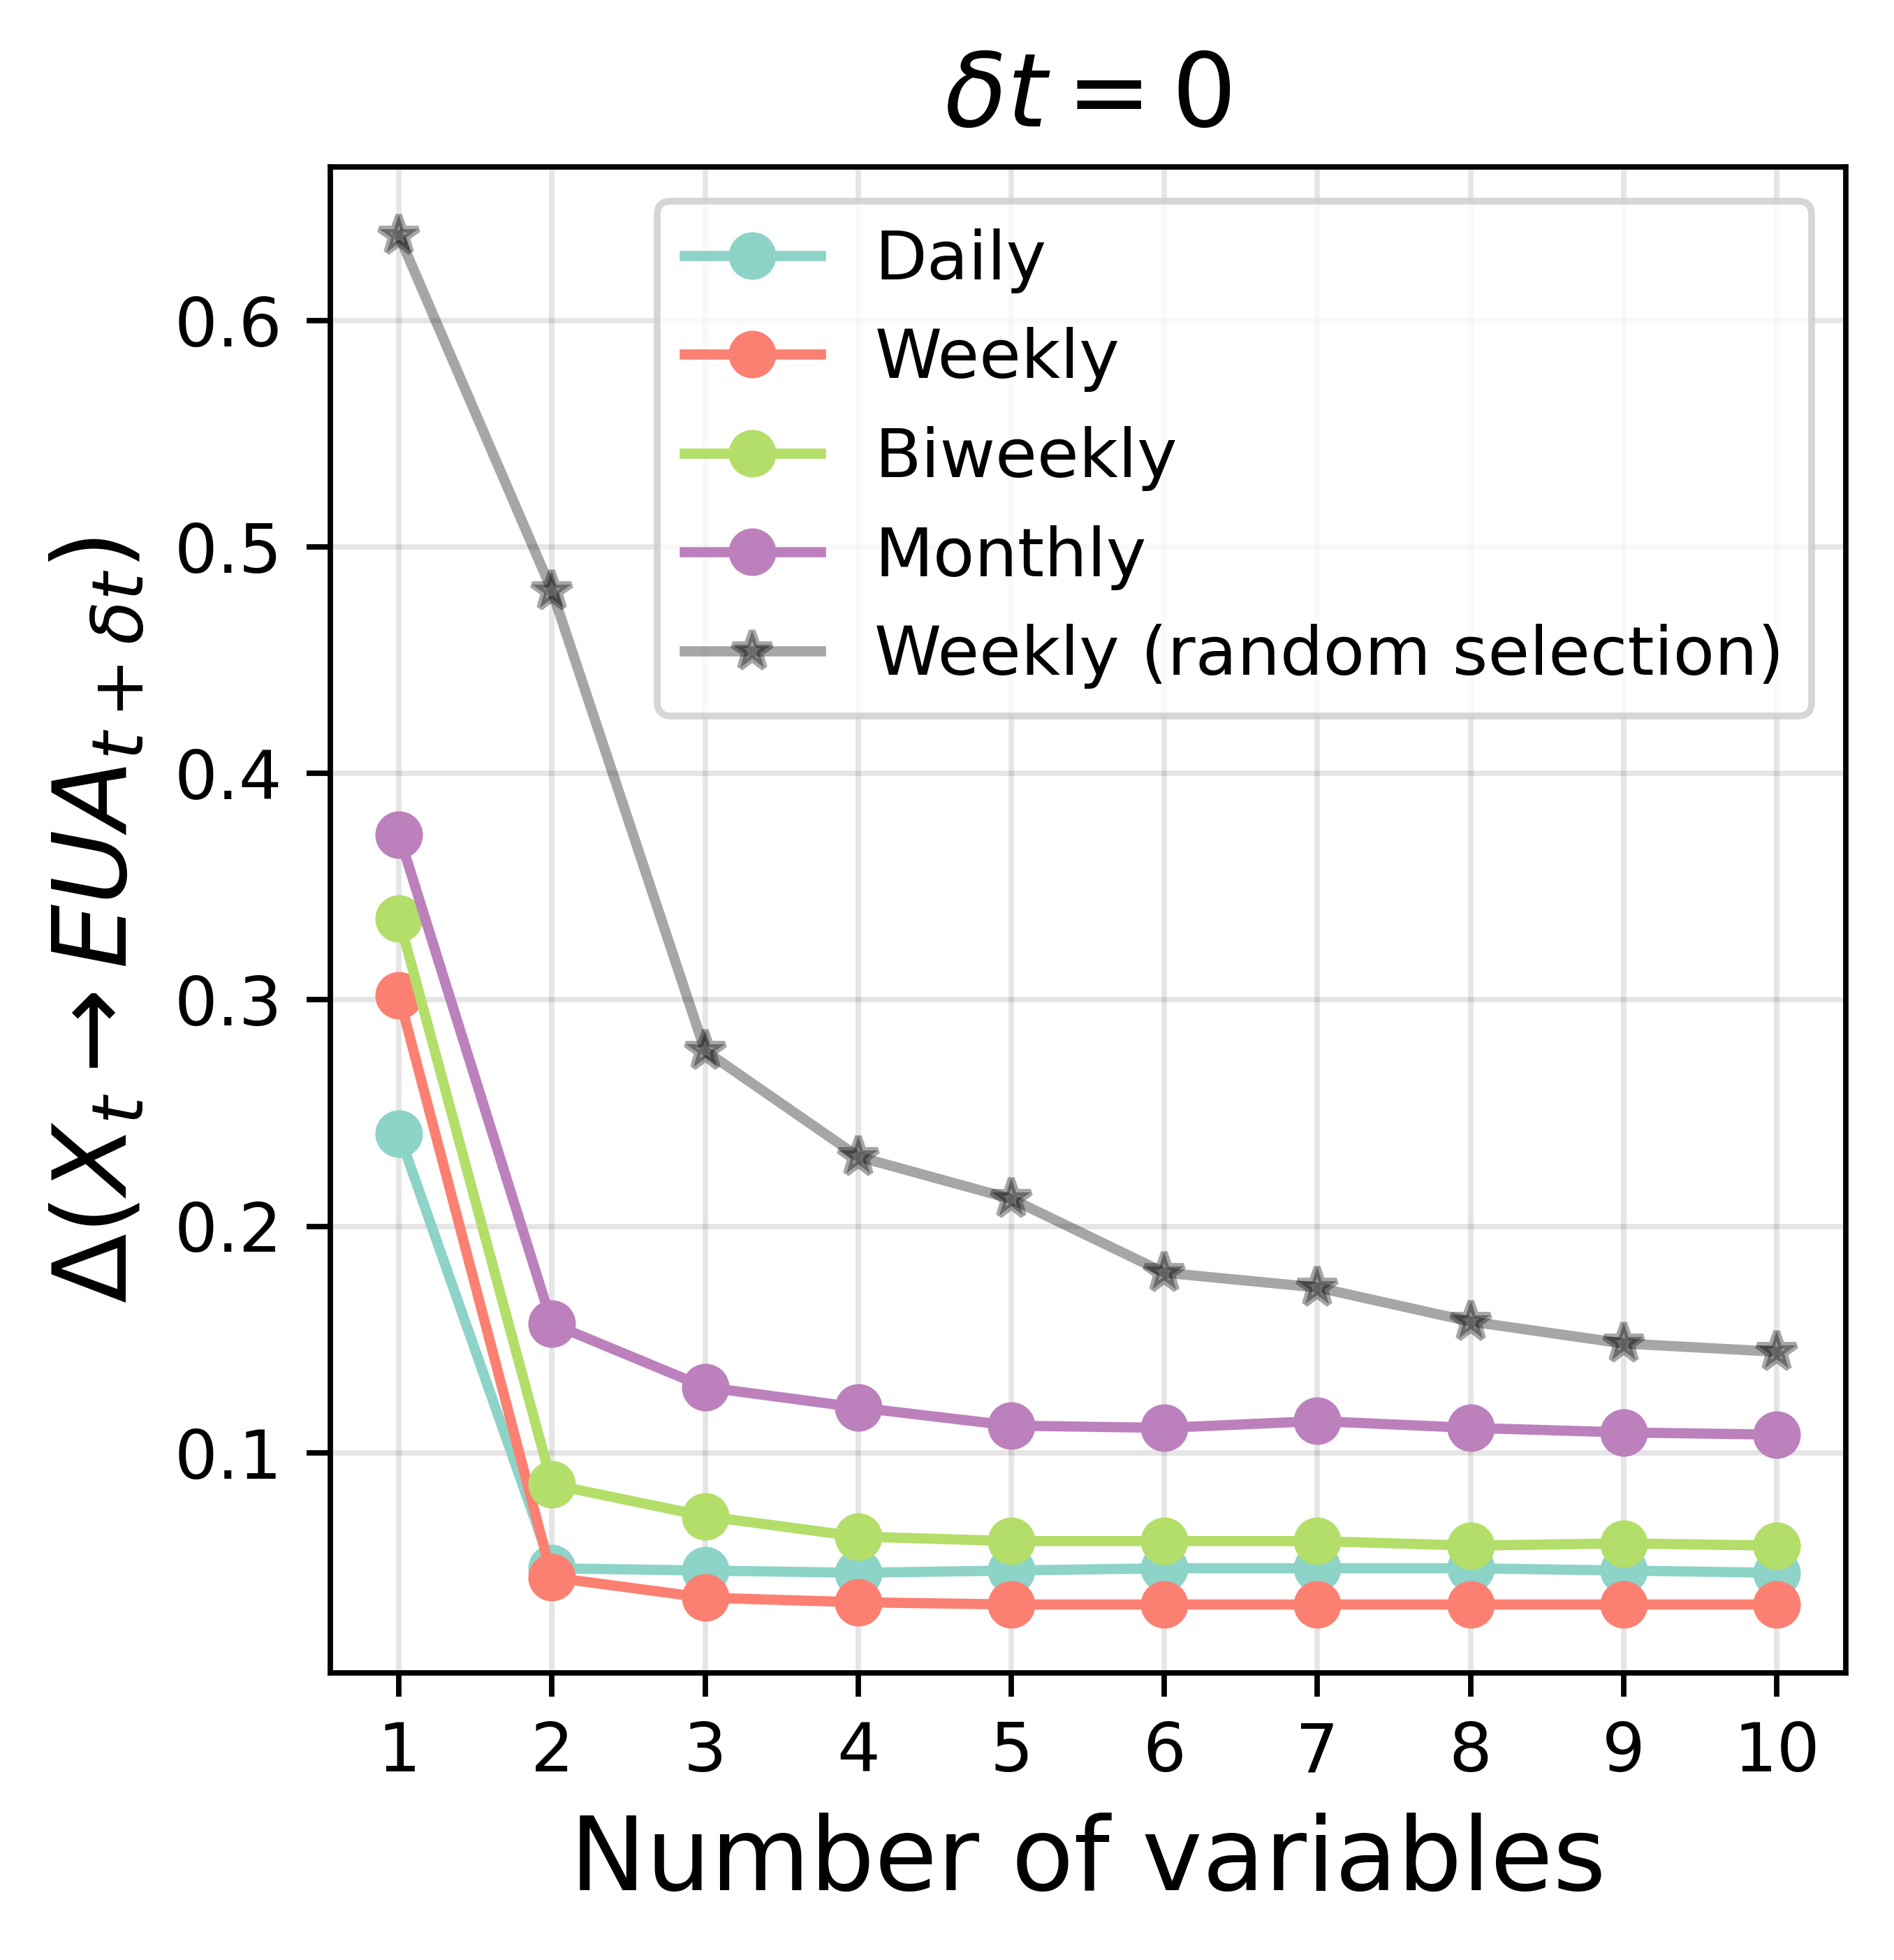

In [11]:
fig, ax = plt.subplots(figsize=(4, 4), dpi = 700)
for i, best_imbs in enumerate(best_imbs_list):
    plt.plot(np.arange(1, 11, 1), best_imbs[0:10, 1], "-o", label = file_labels[i], color = color_scale[i])
plt.plot(np.arange(1, 11, 1), mean_imb, '*-', color='black', label="Weekly (random selection)", alpha=0.35)
plt.legend()
plt.xlabel("Number of variables", fontsize = 15)
plt.ylabel(r'$\Delta(X_{t}\rightarrow EUA_{t+\delta t})$', fontsize = 15)
plt.title(r'$\delta t = 0$', fontsize=15)
plt.grid(axis='both',color="black", alpha=.1)
ax.set_xticks(np.arange(1, 11, 1))
plt.savefig("../Figures/Fig7_1_1_TimeScaleSelection.png", dpi=700, bbox_inches='tight')

Figure 7: Frequency identification and variable selection through the Information Imbalance. The plot shows the Information Imbalance from the predictor set to the EUA price for a growing number of variables in Xt and for different data frequencies, in the same instant of time.

In [ ]:
k = 1

data_sets = []

for file in files:
    data = np.genfromtxt(file)
    data_sets.append(data)

ds_target = []

ds_X = []

n_roll = 1

for data in data_sets:
    target_d = data[:, 0][:, None]
    target_d = np.roll(target_d, -n_roll)[:-n_roll]
    d_t = Data(target_d, maxk = target_d.shape[0]-1 )
    d_t.compute_distances()

    ds_target.append(d_t)

    X = data[:, :]
    X = X[:-n_roll]
    d_X = Data(X, maxk = X.shape[0]-1 )
    d_X.compute_distances() 
    ds_X.append(d_X)

imbalances_1 = []

for d_t, d_X in zip(ds_target, ds_X):

    sing_imbalances = d_X.return_inf_imb_target_all_coords(target_ranks = d_t.dist_indices, k = 1)
    imbalances_1.append(sing_imbalances)

In [ ]:
best_sets_list_2 = []
best_imbs_list_2 = []
all_imbs_list_2 = []

for d_t, d_X in zip(ds_target, ds_X):
    best_sets_2, best_imbs_2, all_imbs_2 = d_X.greedy_feature_selection_target(target_ranks = d_t.dist_indices, 
                                          n_coords=32, k = 1, n_best=1, symm = False)
    best_sets_list_2.append(best_sets_2)
    best_imbs_list_2.append(best_imbs_2)
    all_imbs_list_2.append(all_imbs_2)

In [14]:
data_weekly = np.genfromtxt(files[1])

n_roll = 1
target_w = data_weekly[:, 0][:, None]
target_w_l = np.roll(target_w, -n_roll)[:-n_roll]

d_t_w = Data(target_w_l+np.random.normal(0, 1e-3, size=target_w_l.shape), maxk = target_w_l.shape[0]-1)
d_t_w.compute_distances()

X_w = data_weekly[:, :]
X_w_l = X_w[:-n_roll]

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/dadapy/metric_comparisons.py:60: UserWarning: data type is float64: most methods work only with float-type inputs
  super().__init__(


In [15]:
x = list(range(0,34,1))

np.random.seed(18)
for t in range(1,11):
    for _ in range(1,11):
        sample = random.sample(x, _)

In [ ]:
mean_imb = np.zeros((10,10))
np.random.seed(18)
for t in range(1,11):
    for i in range(1,11):
        sample = random.sample(x, i)
        X_random = X_w_l[:,sample]
        d_X_random = Data(X_random+np.random.normal(0, 1e-3, size=X_random.shape), maxk = X_random.shape[0]-1)
        d_X_random.compute_distances()
        sing_imbalances = d_X_random.return_inf_imb_target_selected_coords(target_ranks = d_t_w.dist_indices, coord_list=[np.arange(i)], k = 1)
        mean_imb[t-1,i-1] = sing_imbalances[1]

In [17]:
mean_imb = np.mean(mean_imb, axis=0)
x = np.arange(1, 11, 1)
x =[]
for i in range(1,11):
    x.append(i)

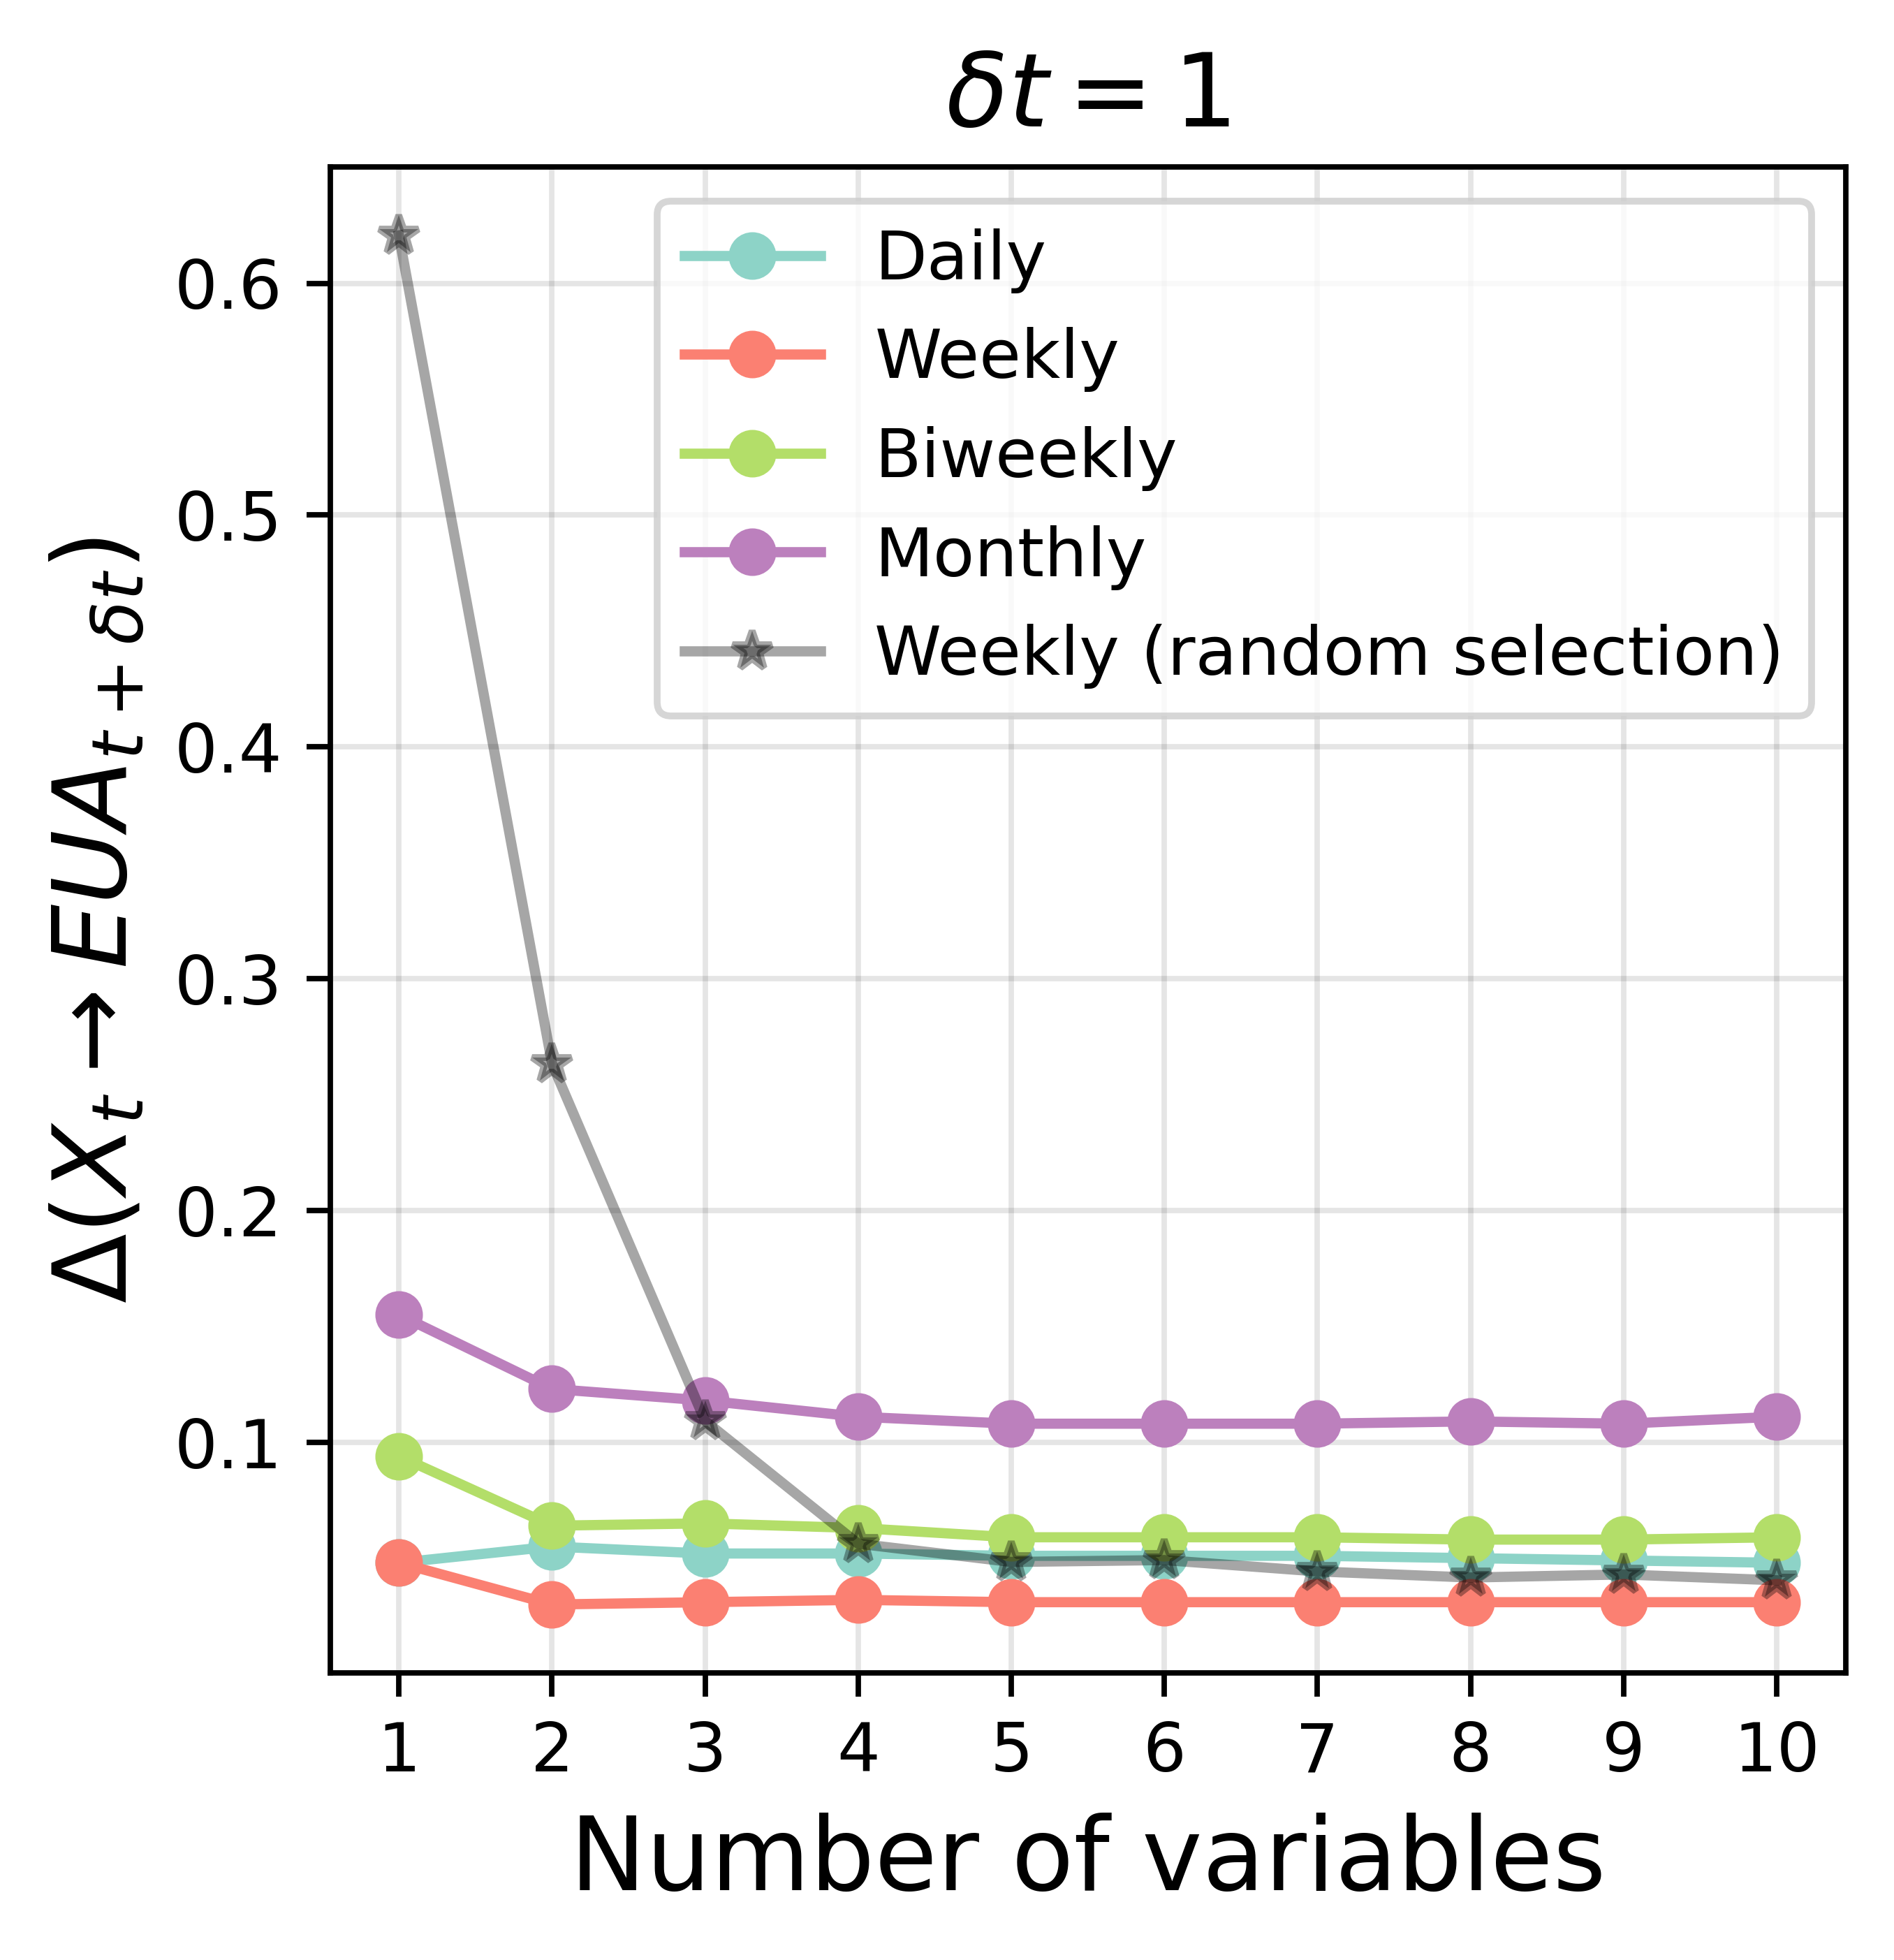

In [18]:
fig, ax = plt.subplots(figsize=(4, 4), dpi = 700)
for i, best_imbs_2 in enumerate(best_imbs_list_2):
    plt.plot(np.arange(1, 11, 1), best_imbs_2[0:10, 1], "-o", label = file_labels[i], color = color_scale[i])
plt.plot(np.arange(1, 11, 1), mean_imb, '*-', color='black', label="Weekly (random selection)", alpha=0.35)
plt.legend()
ax.set_xlabel("Number of variables", fontsize = 15)
ax.set_ylabel(r'$\Delta(X_{t} \rightarrow EUA_{t+\delta t})$', fontsize=15)
plt.title(r'$\delta t = 1$', fontsize=15)
plt.grid(axis='both',color="black", alpha=.1)
ax.set_xticks(np.arange(1, 11, 1))
plt.savefig("../Figures/Fig7_1_2_TimeScaleSelection.png", dpi = 700, bbox_inches='tight')


Figure 7: Frequency identification and variable selection through the Information Imbalance. The plot shows the Information Imbalance from the predictor set to the EUA price for a growing number of variables in Xt and for different data frequencies, with one time lag.

***

In [1]:
%reset -f

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from dadapy import Data

plt.rcParams['text.usetex'] = True

In [ ]:
NUM_COLORS1 = 33
cm = plt.get_cmap('Wistia')
colors1 = [cm(1.*i/NUM_COLORS1) for i in range(NUM_COLORS1)]
colors1_test = np.array(colors1)
colors1_test = colors1_test[::-1]

NUM_COLORS_g = 10
cm2 = plt.get_cmap('Set3')
colors_g = [cm2(1.*i/NUM_COLORS_g) for i in range(NUM_COLORS_g)]

In [ ]:
files = ["../Data/weekly_data.txt"]
file_labels = ["week"]

X_labels = np.array(['GPR', 'VSTOXX', 'Unc. EUR/USD', 'Unc. EUR/JPY', 'Unc. EUR/GBP', 'Unc. EUR/CHF',
       'Nat. Gas', 'Elec. p. SPAIN', 'Elec. p. GER', 'Elec. p. IT',
       'Elec. p. FR', 'Brent Oil', 'Coal', 'Gold', 'EUR/USD Spot',
       'EUR/JPY Spot', 'EUR/GBP Spot', 'EUR/CHF Spot',
       'Bloom. Energy p. ind.', 'Sol. ESG fossil ind.',
       'SP Euro50 Env. ind.', 'MSCI Ener. sec. ind.', 'ERIX ind.', 'EUROnext100', 'IBEX35', 'DAX',
       'CAC', 'FTSEmib', 'EUROSTOXX Elect. ind.', '10 Year Bond y.', '3 Month Bond y.',
       'Inflation', 'GDP'])

In [ ]:
data_sets = []

for file in files:
    data = np.genfromtxt(file)
    data_sets.append(data)

data_weekly = np.genfromtxt(files[0])

target_w = []
X = []

target_w = data_weekly[:, 0][:, None]
X = data_weekly[:, 1:]
X = pd.DataFrame(X, columns=X_labels)
X_labels = X.columns
X = X.to_numpy(dtype=np.float64)[:,]

In [2]:
d_t = Data(target_w+np.random.normal(0, 1e-3, size=target_w.shape), maxk = target_w.shape[0]-1)
d_t.compute_distances()

d_X = Data(X+np.random.normal(0, 1e-3, size=X.shape), maxk = X.shape[0]-1 )
d_X.compute_distances()

sing_imbalances = d_X.return_inf_imb_target_all_coords(target_ranks = d_t.dist_indices, k = 1)
sort_idx = np.argsort(sing_imbalances[1])

total number of computations is:  33


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/dadapy/metric_comparisons.py:60: UserWarning: data type is float64: most methods work only with float-type inputs
  super().__init__(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/dadapy/metric_comparisons.py:60: UserWarning: data type is float64: most methods work only with float-type inputs
  super().__init__(


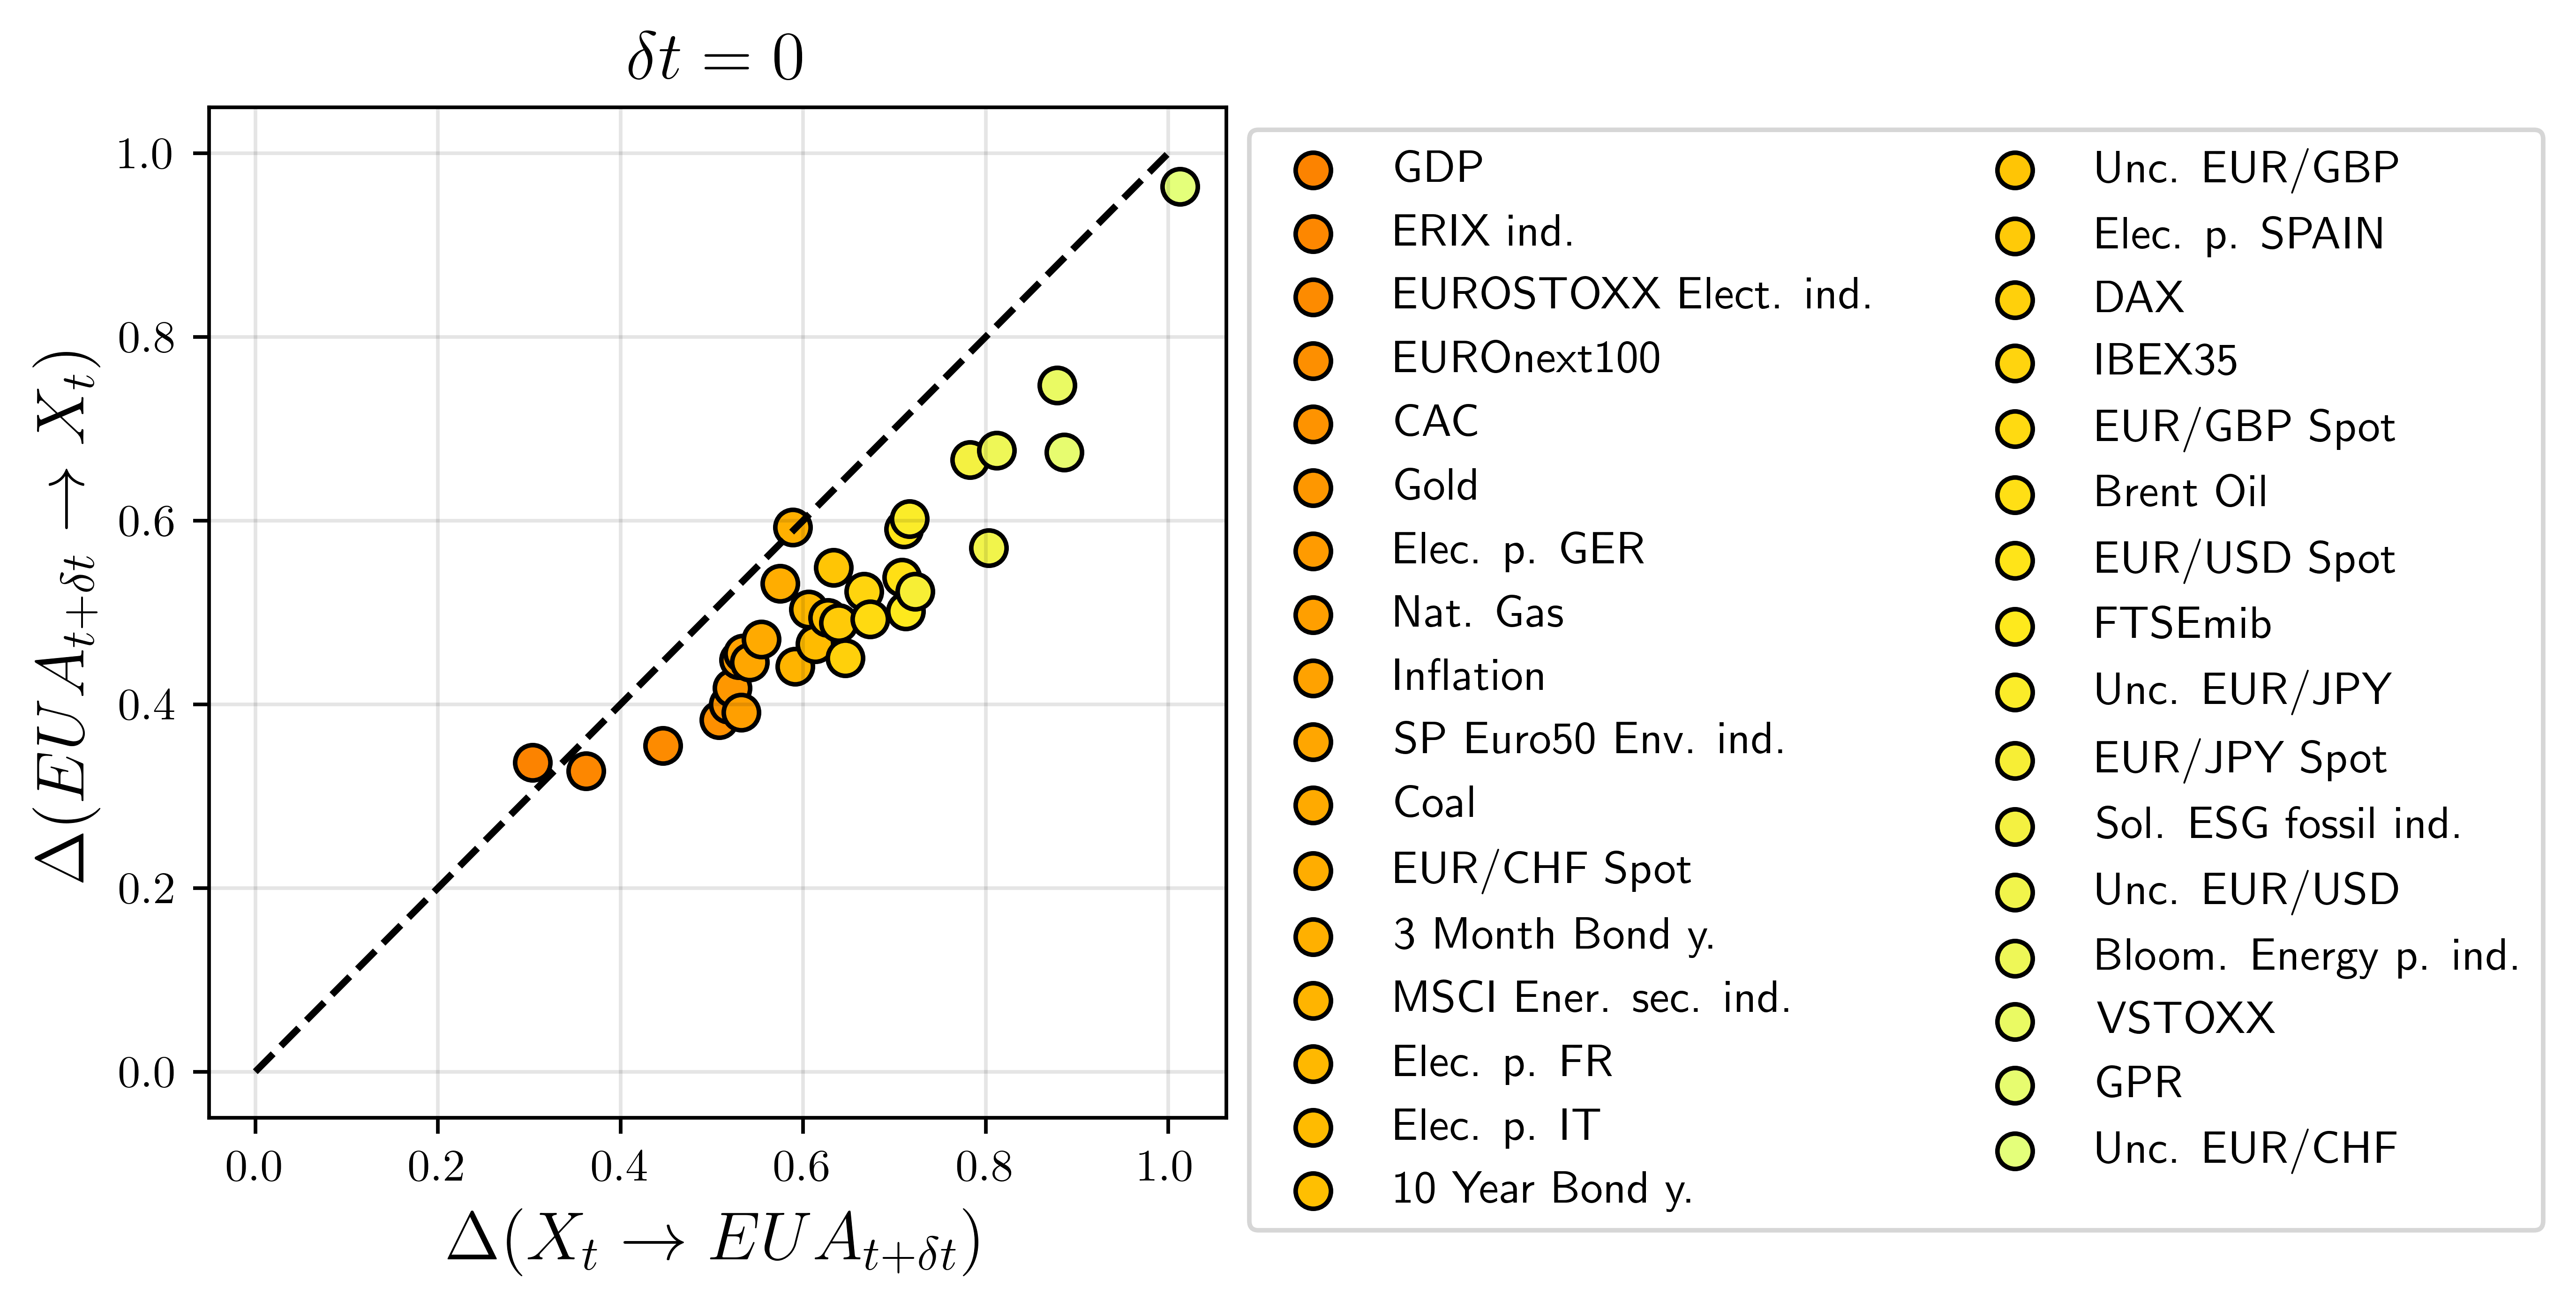

In [3]:
fig, ax = plt.subplots(figsize=(4,4), dpi = 700)

for i, imbs in enumerate(sing_imbalances.T[sort_idx]):
    plt.scatter(imbs[1], imbs[0], color = colors1_test[i], s = 60, edgecolor = 'k', label = X_labels[sort_idx][i])
plt.plot([0, 1], 'k--')
plt.legend(ncol = 2, bbox_to_anchor=(1.0, 1.))
plt.xlabel(r'$\Delta(X_{t} \rightarrow EUA_{t+\delta t})$', fontsize=15)
plt.ylabel(r'$\Delta(EUA_{t+\delta t}\rightarrow X_{t})$', fontsize=15)
plt.title(r'$\delta t = 0$', fontsize=15)
plt.grid(axis='both',color="black", alpha=.1)
#plt.savefig("../Figures/Fig7_2_1_TimeScaleSelection.png", dpi=700, bbox_inches='tight')

Figure 8: Information Imbalance plane for nowcasting and forecasting EUA price. The single variable information content towards the target EUA is presented in the same instant of time.

In [4]:
best_sets, best_imbs, all_imbs = d_X.greedy_feature_selection_target(target_ranks = d_t.dist_indices, 
                                          n_coords=10, 
                                          k = 1, n_best=1, symm = False)

total number of computations is:  33
total number of computations is:  32
total number of computations is:  31
total number of computations is:  30
total number of computations is:  29
total number of computations is:  28
total number of computations is:  27
total number of computations is:  26
total number of computations is:  25
total number of computations is:  24


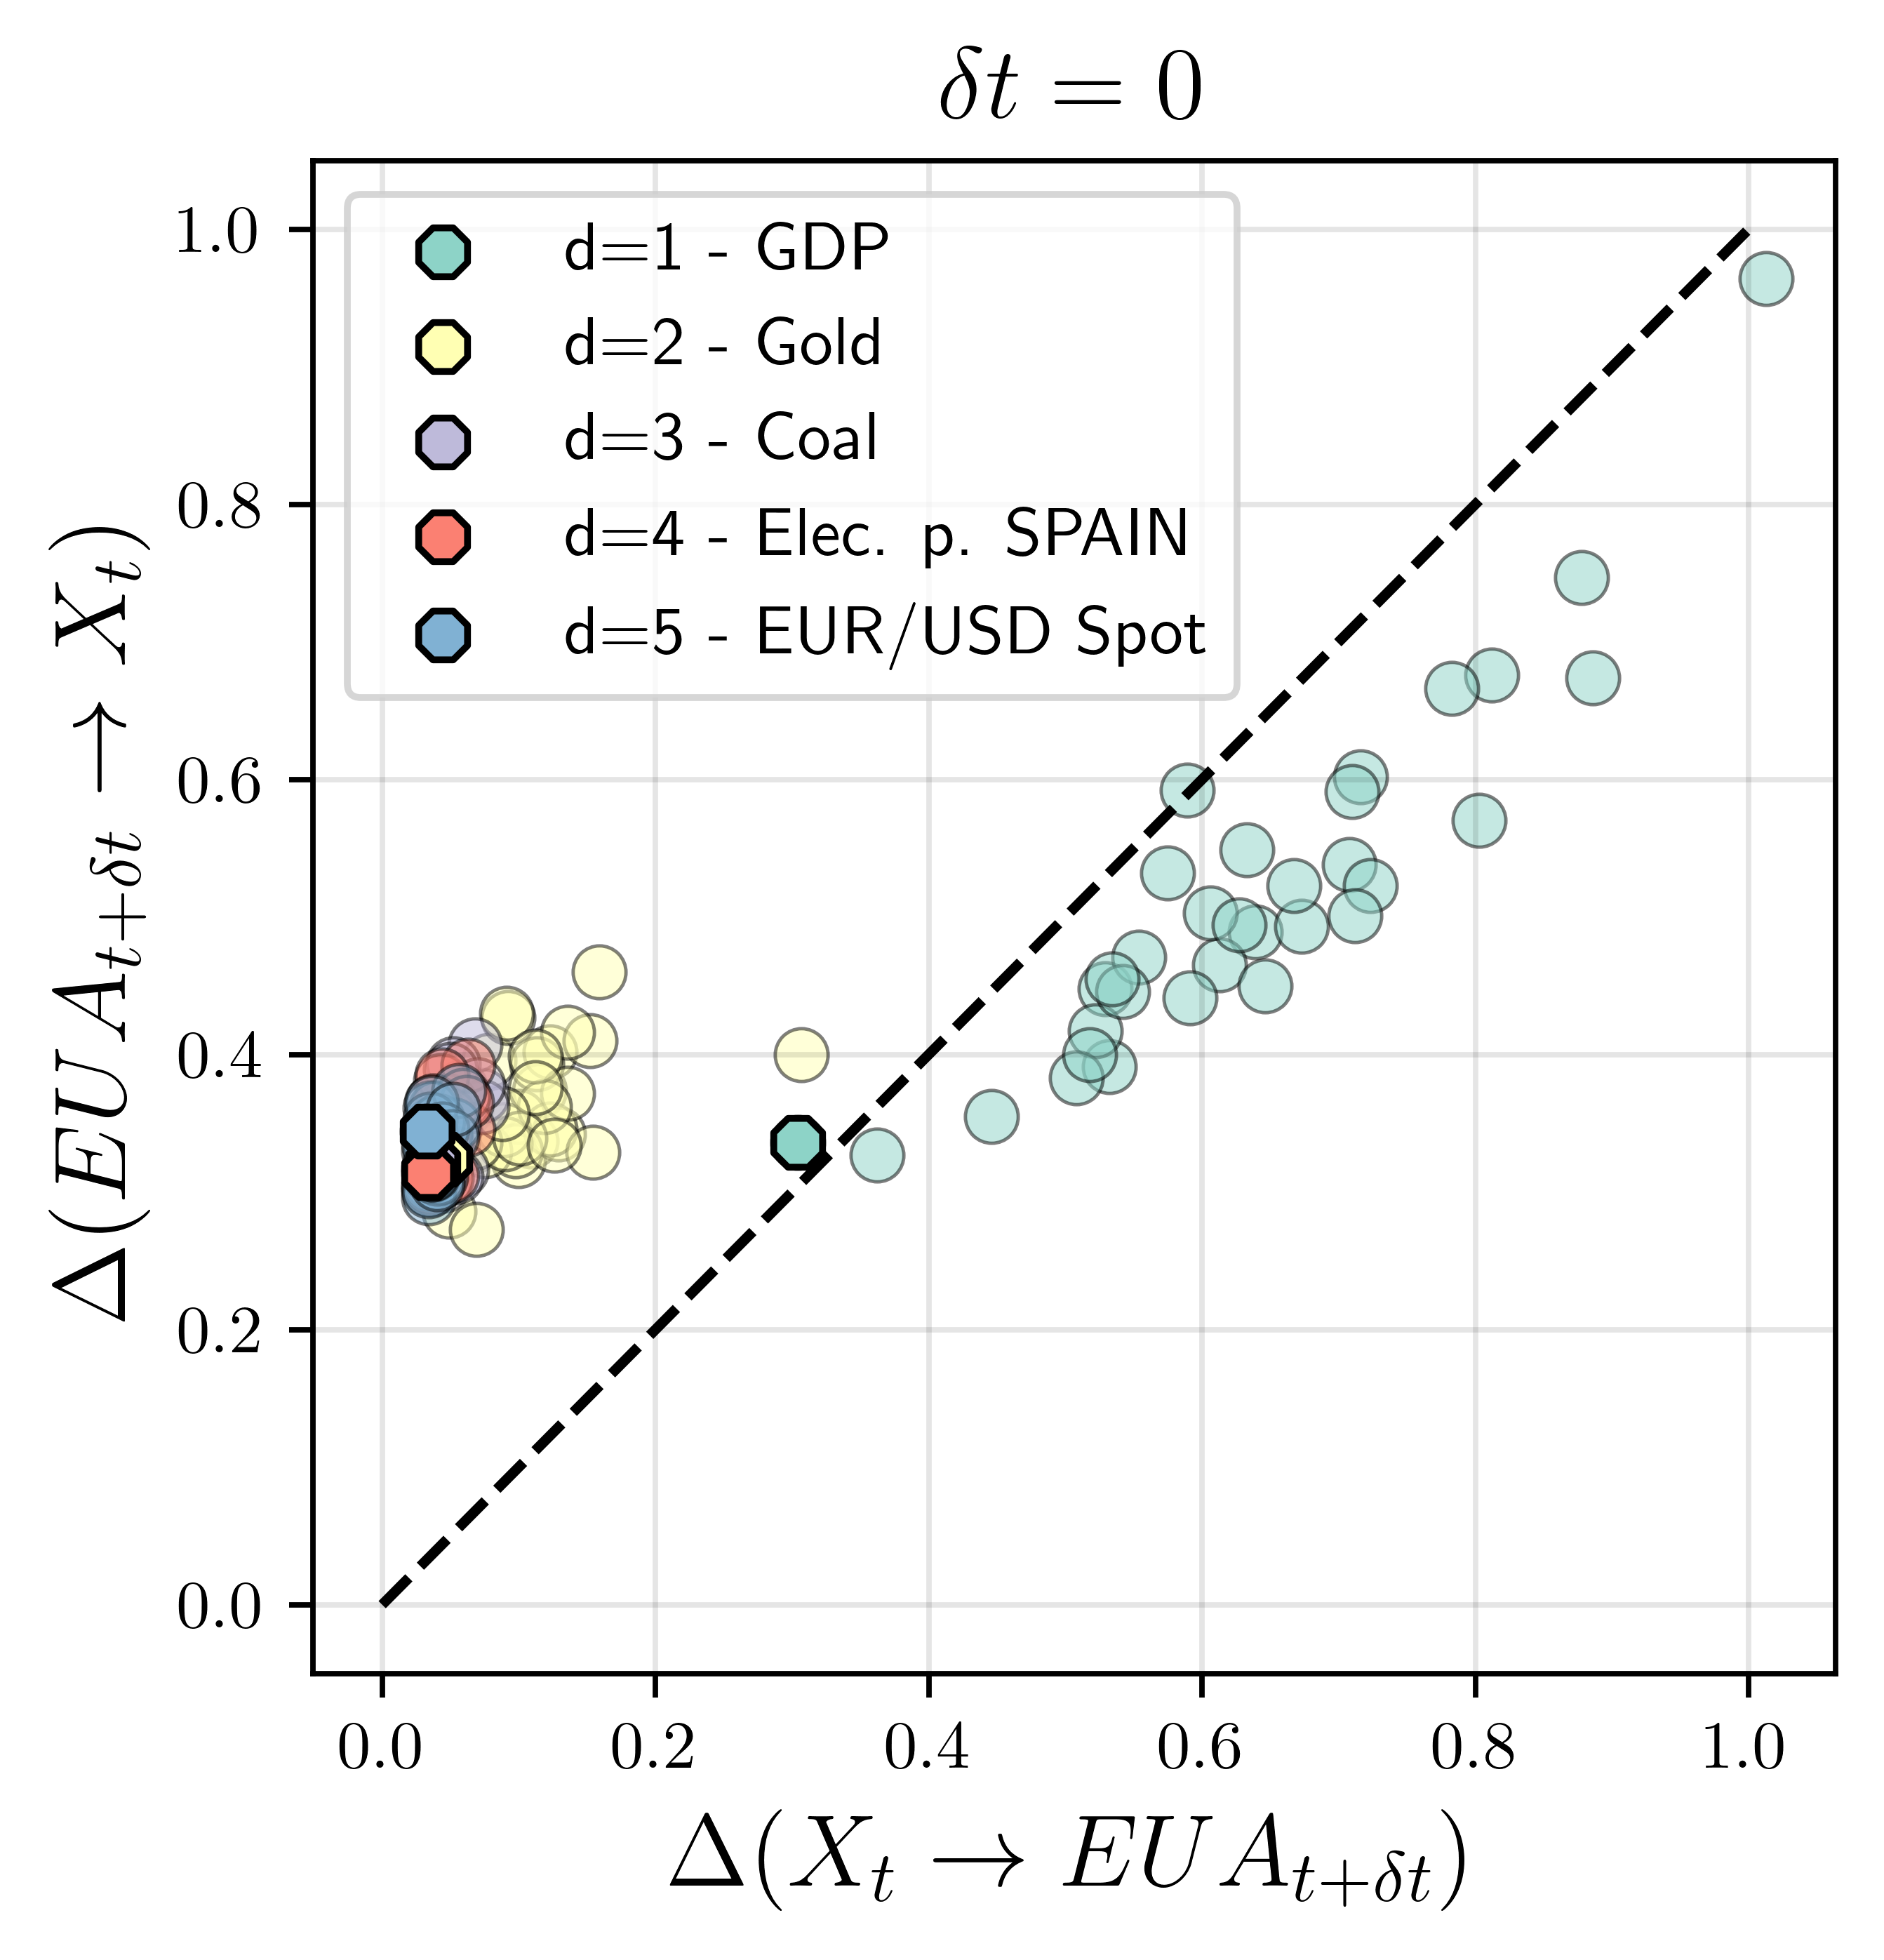

In [5]:
bs0 = set([])
ordered_best_set = []
fig, ax = plt.subplots(figsize=(4, 4), dpi = 700)
for i, (imbs, bs, b_imbs) in enumerate(zip(all_imbs[0:5], best_sets[0:5], best_imbs[0:5])):
    label = ""
    bs1 = set(bs)
    bs1=bs1-bs0
    ordered_best_set.append(list(bs1)[0])
    bs0=set(bs)
    for idx in bs1:
        label=X_labels[idx]
    plt.scatter(imbs[1], imbs[0],color=colors_g[i], s=60, edgecolor ='k', marker = "o", alpha=0.50, zorder=1, linewidths=0.5)
    plt.scatter(b_imbs[1],b_imbs[0],color=colors_g[i], s=60, edgecolor ='k', label = "d=" + str(i+1) + " - " + label, marker = "8", zorder=2)
plt.plot([0, 1], 'k--')
plt.xlabel(r'$\Delta(X_{t} \rightarrow EUA_{t+\delta t})$', fontsize=15)
plt.ylabel(r'$\Delta(EUA_{t+\delta t}\rightarrow X_{t})$', fontsize=15)
plt.title(r'$\delta t = 0$', fontsize=15)
plt.legend(ncol=1, fontsize=10)
plt.grid(axis='both',color="black", alpha=.1)
#plt.savefig("../Figures/Fig7_2_2_TimeScaleSelection.png", dpi=700, bbox_inches='tight')

Figure 7: Frequency identification and variable selection through the Information Imbalance. The plot shows the greedy optimisation process to select the most informative subset, in the same instant of time.

***

In [8]:
%reset -f

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from dadapy import Data

plt.rcParams['text.usetex'] = True

In [10]:
NUM_COLORS1 = 34
cm = plt.get_cmap('Wistia')
colors1 = [cm(1.*i/NUM_COLORS1) for i in range(NUM_COLORS1)]
colors1_test = np.array(colors1)
colors1_test = colors1_test[::-1]

NUM_COLORS_g = 10
cm2 = plt.get_cmap('Set3')
colors_g = [cm2(1.*i/NUM_COLORS_g) for i in range(NUM_COLORS_g)]

In [11]:
files = ["../Data/daily_data.txt", "../Data/weekly_data.txt", "../Data/biweekly_data.txt", "../Data/monthly_data.txt"]
file_labels = ["day", "week", "2 weeks", "month"]
k = 1

X_labels = np.array(['EUA','GPR', 'VSTOXX', 'Unc. EUR/USD', 'Unc. EUR/JPY', 'Unc. EUR/GBP', 'Unc. EUR/CHF',
       'Nat. Gas', 'Elec. p. SPAIN', 'Elec. p. GER', 'Elec. p. IT',
       'Elec. p. FR', 'Brent Oil', 'Coal', 'Gold', 'EUR/USD Spot',
       'EUR/JPY Spot', 'EUR/GBP Spot', 'EUR/CHF Spot',
       'Bloom. Energy p. ind.', 'Sol. ESG fossil ind.',
       'SP Euro50 Env. ind.', 'MSCI Ener. sec. ind.', 'ERIX ind.', 'EUROnext100', 'IBEX35', 'DAX',
       'CAC', 'FTSEmib', 'EUROSTOXX Elect. ind.', '10 Year Bond y.', '3 Month Bond y.',
       'Inflation', 'GDP'])

In [12]:
data_sets = []

for file in files:
    data = np.genfromtxt(file)
    data_sets.append(data)

In [13]:
data_weekly = np.genfromtxt(files[1])
n_roll = 1

In [14]:
target_w = data_weekly[:, 0][:, None]
target_w_l = np.roll(target_w, -n_roll)[:-n_roll]

d_t_w = Data(target_w_l+np.random.normal(0, 1e-3, size=target_w_l.shape), maxk = target_w_l.shape[0]-1)
d_t_w.compute_distances()

X_w = data_weekly[:, :]
X_w_l = X_w[:-n_roll]

d_X_w = Data(X_w_l+np.random.normal(0, 1e-3, size=X_w_l.shape), maxk = X_w_l.shape[0]-1)
d_X_w.compute_distances()

sing_imbalances_w = d_X_w.return_inf_imb_target_all_coords(target_ranks = d_t_w.dist_indices, k = 1)
sort_idx_w = np.argsort(sing_imbalances_w[1])

total number of computations is:  34


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/dadapy/metric_comparisons.py:60: UserWarning: data type is float64: most methods work only with float-type inputs
  super().__init__(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/dadapy/metric_comparisons.py:60: UserWarning: data type is float64: most methods work only with float-type inputs
  super().__init__(


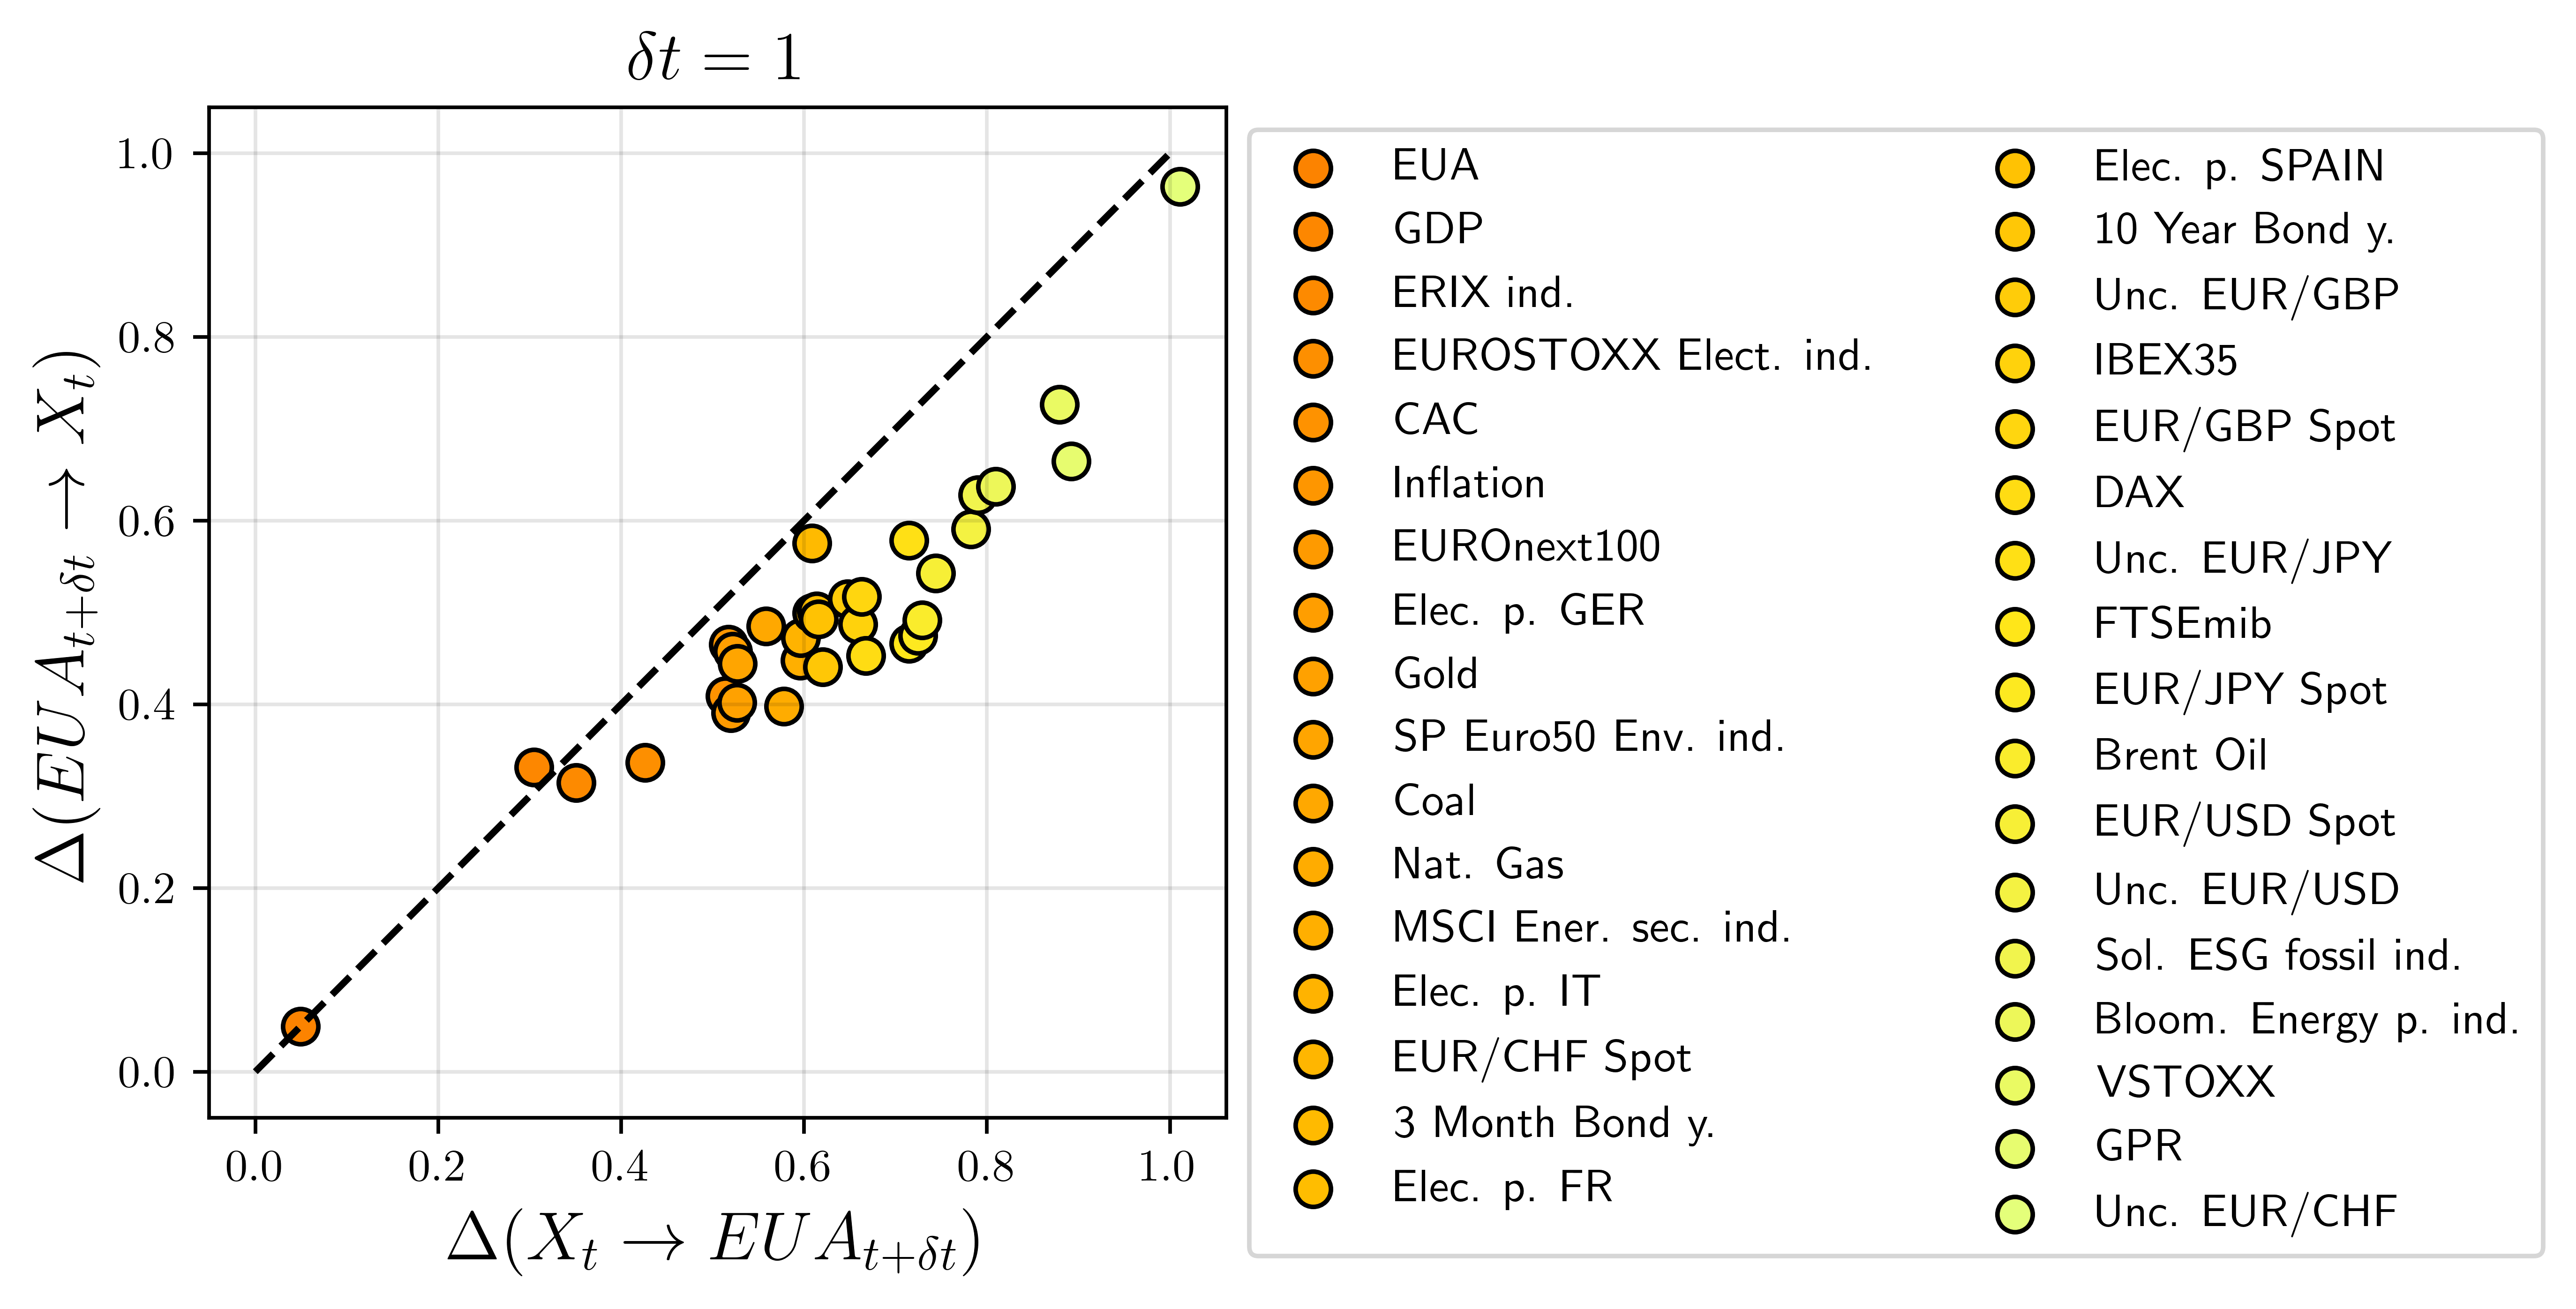

In [15]:
fig, ax = plt.subplots(figsize=(4,4), dpi = 700)
for i, imbs in enumerate(sing_imbalances_w.T[sort_idx_w]):
    plt.scatter(imbs[1], imbs[0], color = colors1_test[i], s=60, edgecolor ='k', label = X_labels[sort_idx_w][i])
plt.plot([0, 1], 'k--')
plt.legend(ncol = 2, bbox_to_anchor=(1.0, 1.))
plt.xlabel(r'$\Delta(X_{t} \rightarrow EUA_{t+\delta t})$', fontsize=15)
plt.ylabel(r'$\Delta(EUA_{t+\delta t}\rightarrow X_{t})$', fontsize=15)
plt.title(r'$\delta t = 1$', fontsize=15)
plt.grid(axis='both',color="black", alpha=.1)
#plt.savefig("../Figures/Fig7_2_1_TimeScaleSelection.png", dpi = 700, bbox_inches='tight')

Figure 8: Information Imbalance plane for nowcasting and forecasting EUA price. The single variable information content towards the target EUA is presented with 1 time lag.

In [17]:
best_sets, best_imbs, all_imbs = d_X_w.greedy_feature_selection_target(target_ranks = d_t_w.dist_indices, 
                                          n_coords=10, 
                                          k = 1, n_best=1, symm = False)

total number of computations is:  34
total number of computations is:  33
total number of computations is:  32
total number of computations is:  31
total number of computations is:  30
total number of computations is:  29
total number of computations is:  28
total number of computations is:  27
total number of computations is:  26
total number of computations is:  25


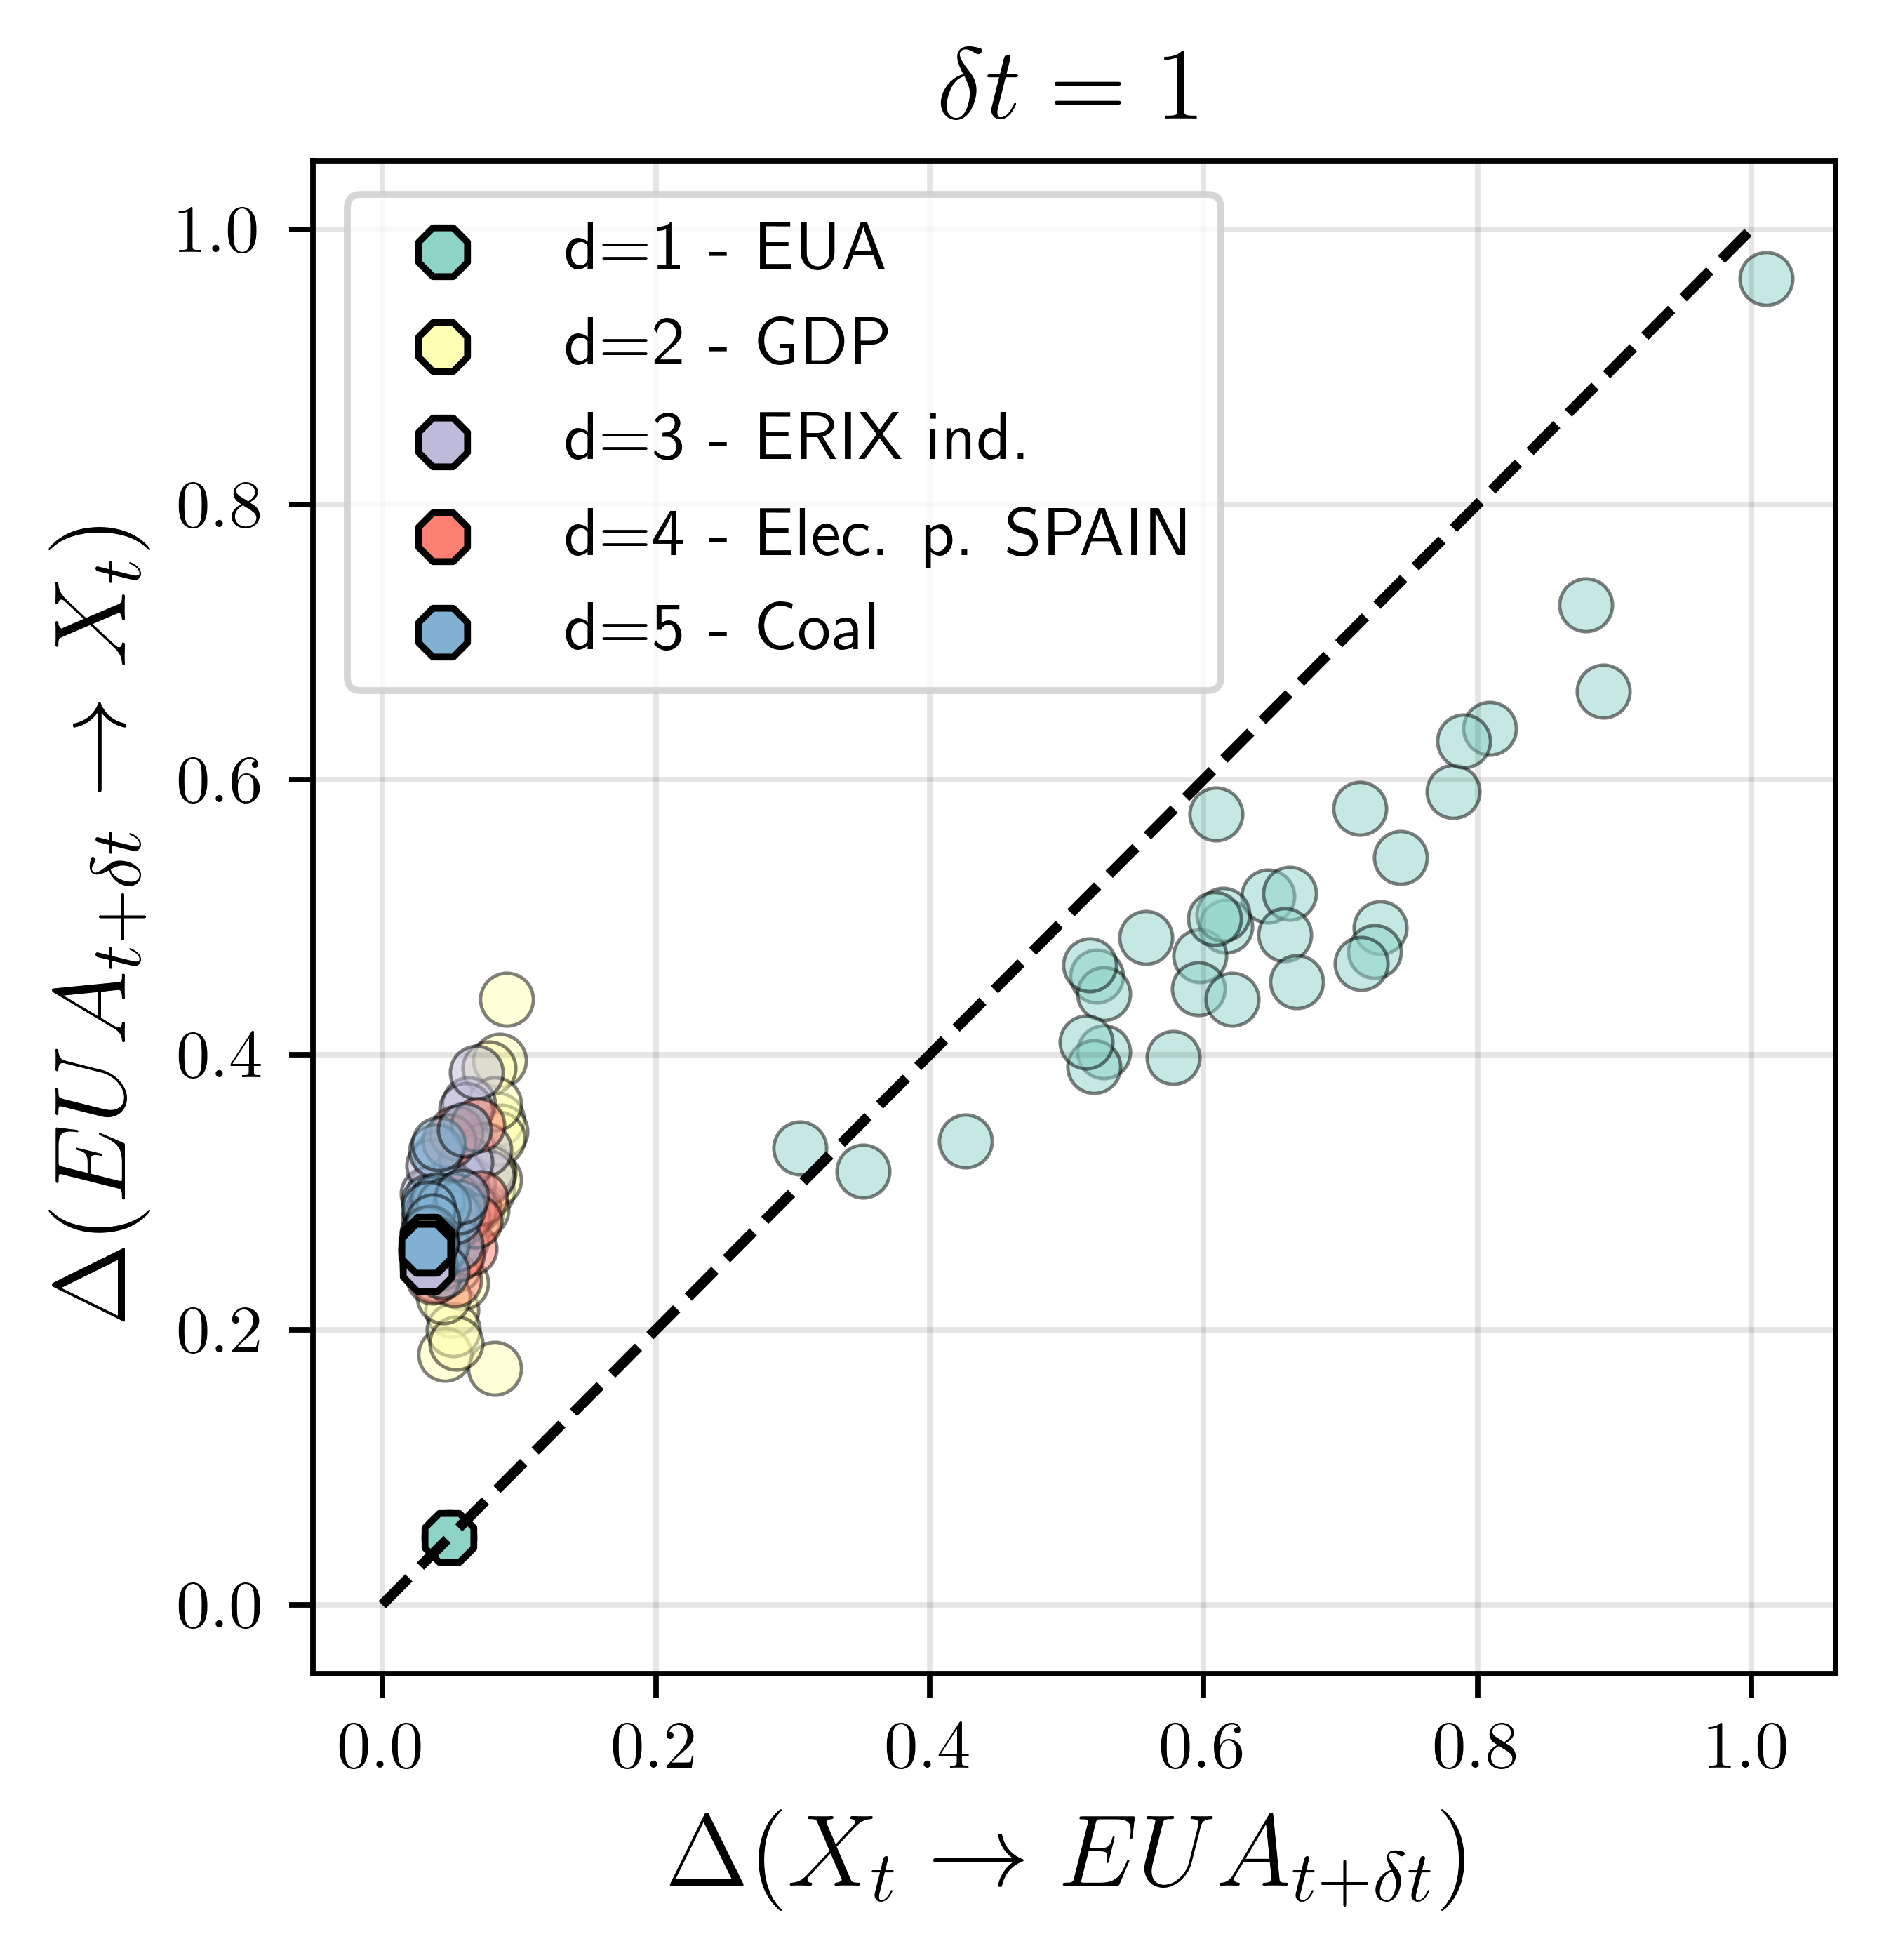

In [18]:
bs0 = set([])
ordered_best_set = []
fig, ax = plt.subplots(figsize=(4, 4), dpi = 700)
for i, (imbs, bs, b_imbs) in enumerate(zip(all_imbs[0:5], best_sets[0:5], best_imbs[0:5])):
    label = ""
    bs1 = set(bs)
    bs1=bs1-bs0
    ordered_best_set.append(list(bs1)[0])
    bs0=set(bs)
    for idx in bs1:
        label=X_labels[idx]
    plt.scatter(imbs[1], imbs[0],color=colors_g[i], s=60, edgecolor ='k', marker = "o", alpha=0.50, zorder=1, linewidths=0.5)
    plt.scatter(b_imbs[1],b_imbs[0],color=colors_g[i], s=60, edgecolor ='k', label = "d=" + str(i+1) + " - " + label, marker = "8", zorder=2)
plt.plot([0, 1], 'k--')
plt.xlabel(r'$\Delta(X_{t} \rightarrow EUA_{t+\delta t})$', fontsize=15)
plt.ylabel(r'$\Delta(EUA_{t+\delta t}\rightarrow X_{t})$', fontsize=15)
plt.title(r'$\delta t =1$', fontsize=15)
plt.legend(ncol=1, fontsize=10)
plt.grid(axis='both',color="black", alpha=.1)
#plt.savefig("../Figures/Fig7_2_2_TimeScaleSelection.png", dpi = 700, bbox_inches='tight')

Figure 7: Frequency identification and variable selection through the Information Imbalance. The plot shows the greedy optimisation process to select the most informative subset, with one time lag.

In [19]:
ordered_best_set = np.array(ordered_best_set)
labels_forecasting = X_labels[ordered_best_set]

Text(0.5, 1.0, '$\\delta t = 1$')

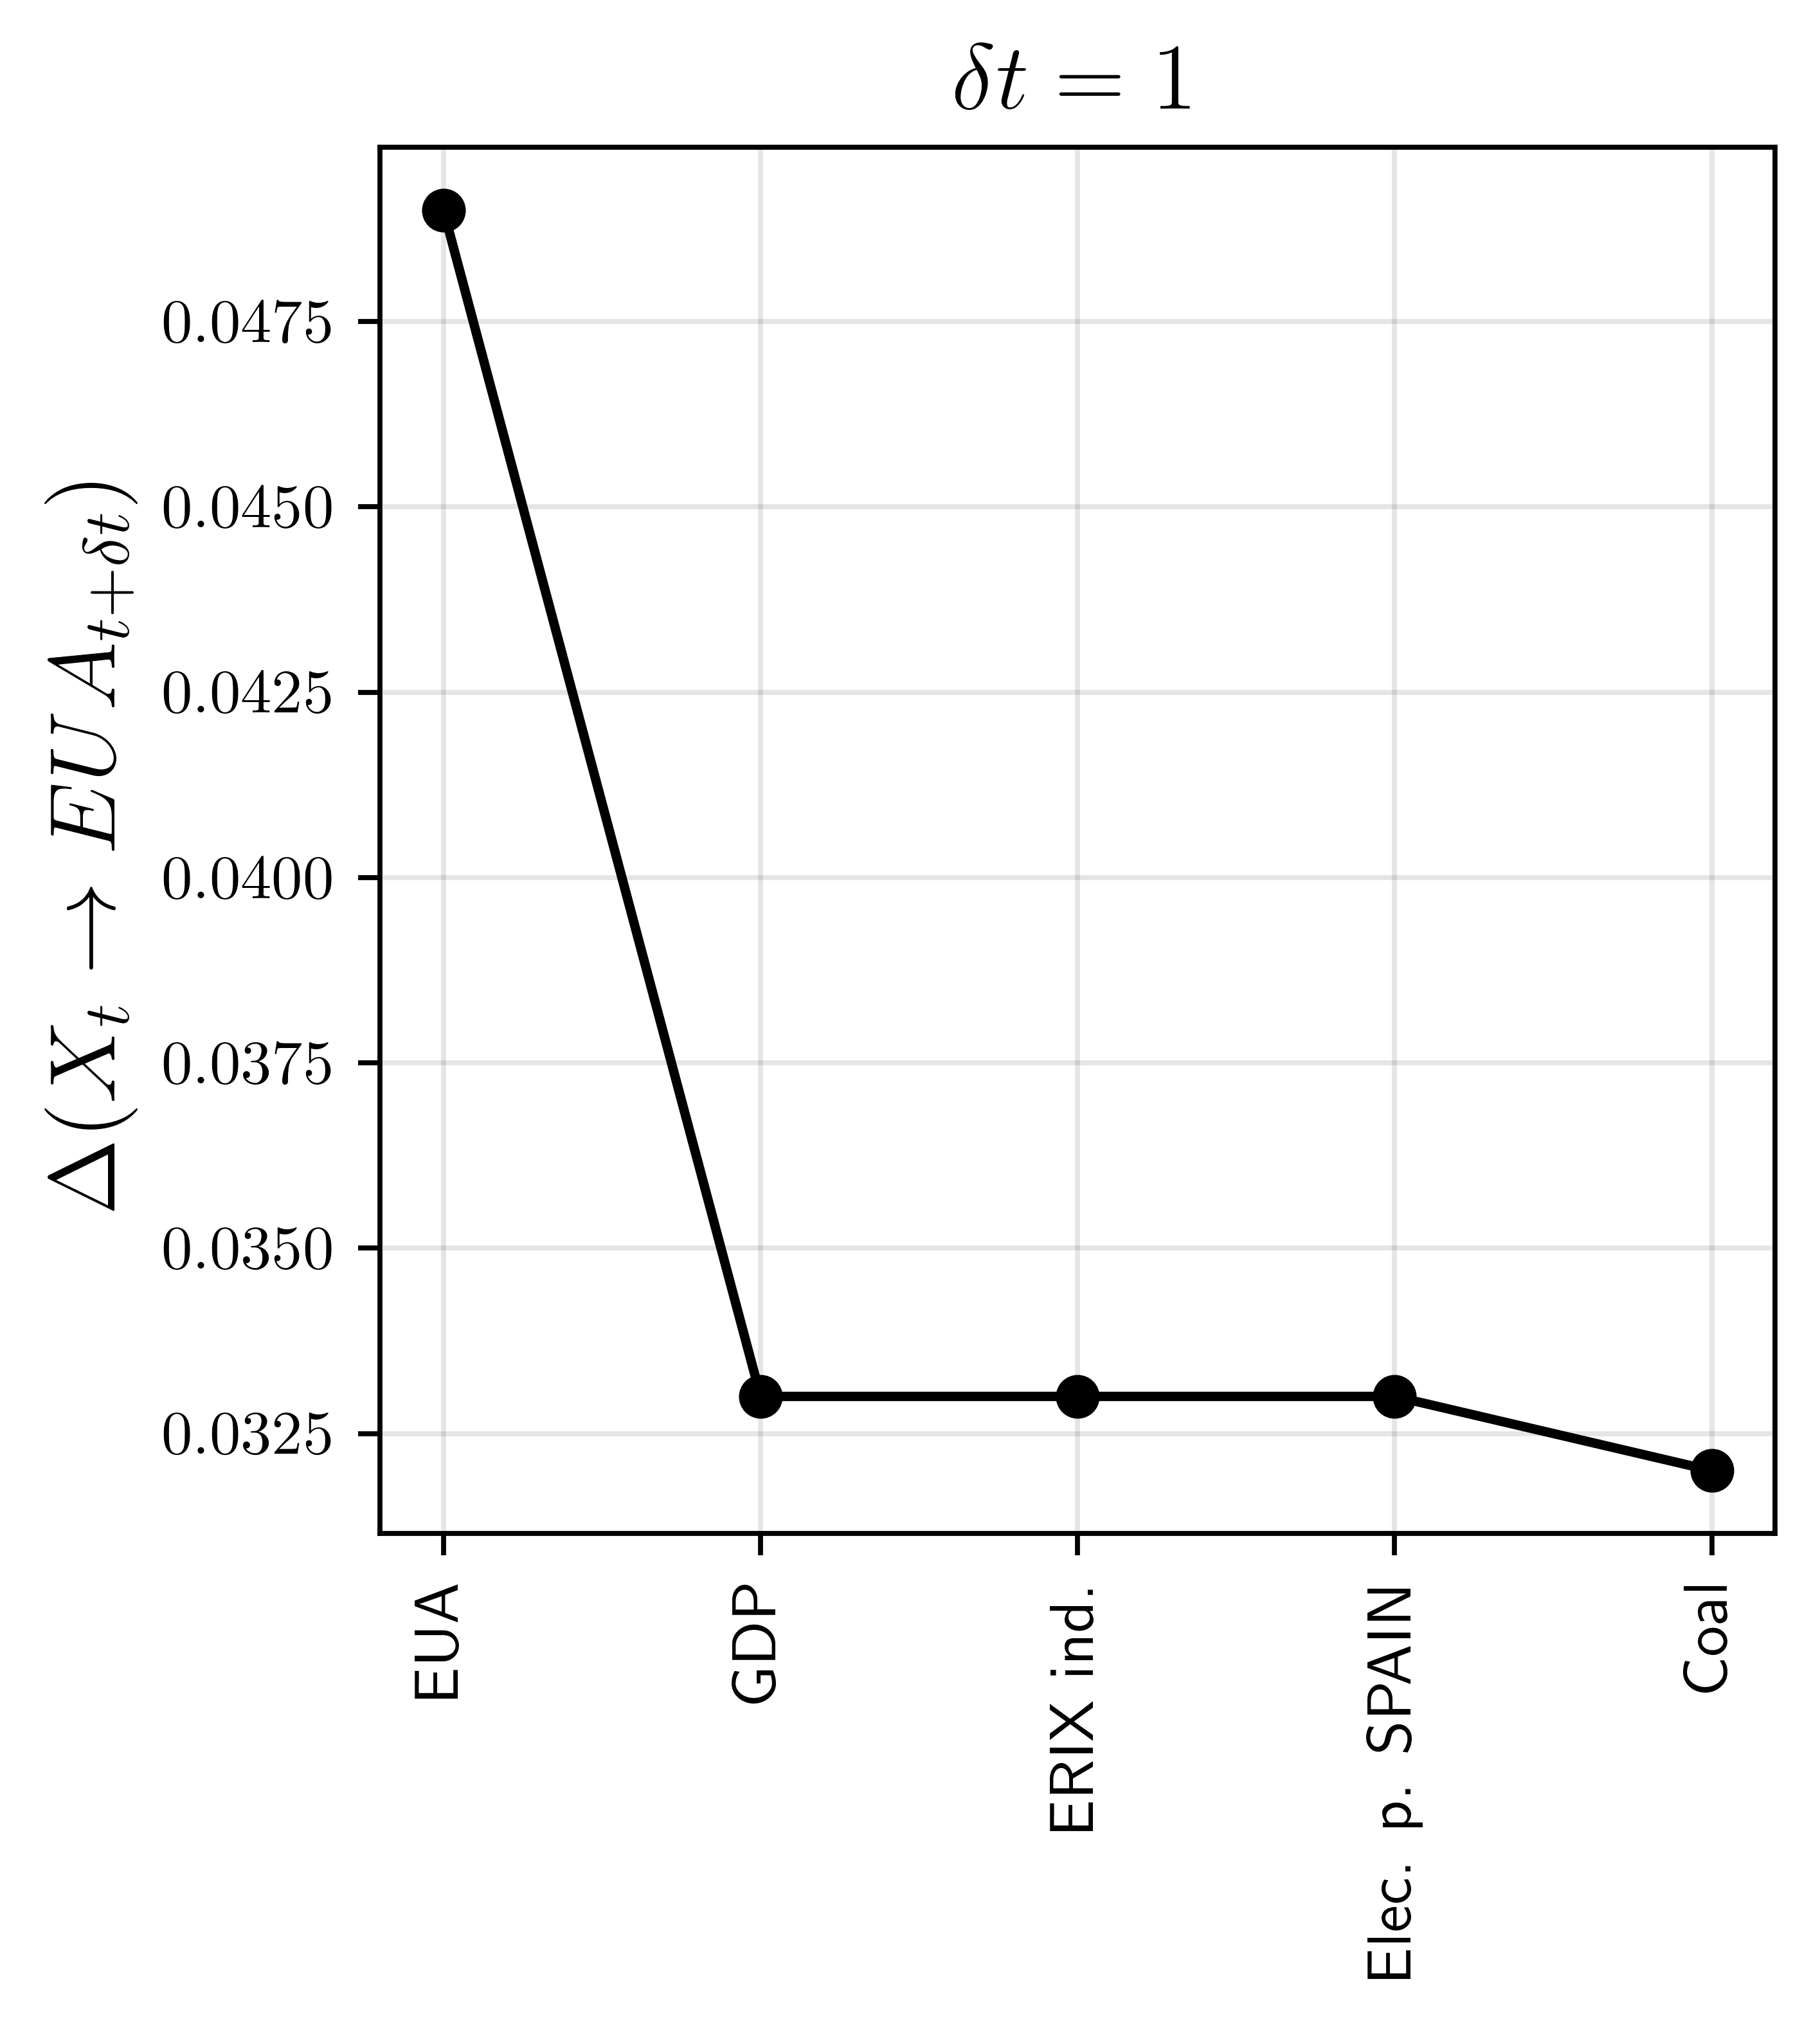

In [20]:
plt.figure(figsize=(4, 4), dpi = 700)
plt.plot(labels_forecasting, best_imbs[0:5, 1], '-o',  color ='k')
plt.ylabel(r'$\Delta(X_{t} \rightarrow EUA_{t+\delta t})$', fontsize=15)
plt.xticks(rotation=90)
plt.grid(axis='both',color="black", alpha=.1)
plt.title(r'$\delta t = 1$', fontsize=15)
#plt.savefig("../Figures/Fig7_2_3_TimeScaleSelection.png", dpi = 700, bbox_inches='tight')

***

## 5.2 Selection of predictor variables

In [29]:
%reset -f

In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn.gaussian_process.kernels as k
import sklearn.model_selection as ms
from dadapy import Data
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
from itertools import combinations

plt.rcParams['text.usetex'] = True

In [31]:
np.random.seed(0)

In [32]:
df = pd.read_excel('../Data/Dataset_eua_IMv4.3.xlsx')
eua = df['eua_last']

In [33]:
files = ["../Data/weekly_data.txt"]
file_label = ["Weekly"]
X_labels = np.array(['GPR', 'VSTOXX', 'Unc. EUR/USD', 'Unc. EUR/JPY', 'Unc. EUR/GBP', 'Unc. EUR/CHF',
       'Natural Gas', 'Elec. price SPAIN', 'Elec. price GER', 'Elec. price IT',
       'Elec. price FR', 'Brent Oil', 'Coal', 'Gold', 'EUR/USD Spot',
       'EUR/JPY Spot', 'EUR/GBP Spot', 'EUR/CHF Spot',
       'Bloom. Energy price index', 'Solactive ESG fossil index',
       'S&P Euro50 Env. index', 'MSCI EU Energy sec. index', 'ERIX index', 'EUROnext100', 'IBEX35', 'DAX',
       'CAC', 'FTSEmib', 'EUROSTOXX. Elect. index', '10 Year Bond yield', '3 Month Bond Yield',
       'Inflation', 'GDP'])

In [34]:
data_sets = []
for file in files:
    data = np.genfromtxt(file)
    data_sets.append(data)
data_weekly = np.genfromtxt(files[0])

target_w = data_weekly[:, 0][:, None]
X_w = data_weekly[:, 1:]
X_w_im = data_weekly[:, 1:][:, [32, 13, 12]]

In [35]:
kernel_w_s =k.Matern(length_scale=1, length_scale_bounds=(1e-5, 1e5), nu=1.5)
kf = KFold(n_splits=5, shuffle=True, random_state=0)

In [36]:
test_indices_alls = []
y_pred_now_alls = []
r_2_now_alls = []
mse_list_now_alls = []
mse_list_now_ims = []

for train_index, test_index in kf.split(X_w):
    test_indices_alls.append(test_index)
    X_train_now_all, X_test_now_all = X_w[train_index], X_w[test_index]
    y_train_now_all, y_test_now_all = target_w[train_index], target_w[test_index]
    gpr_now_all = GaussianProcessRegressor(kernel=kernel_w_s, n_restarts_optimizer=10, alpha=0.001, normalize_y=True)
    gpr_now_all.fit(X_train_now_all, y_train_now_all)
    y_pred_now_all, sigma_now_all = gpr_now_all.predict(X_test_now_all, return_std=True)
    y_pred_now_alls.append(y_pred_now_all)
    r_2_now_all = gpr_now_all.score(X_test_now_all, y_test_now_all)
    r_2_now_alls.append(r_2_now_all)
    mse_list_now_alls.append(mean_squared_error(y_test_now_all, y_pred_now_all))

all_test_indices_alls = np.concatenate([ti for ti in test_indices_alls])
to_sort_alls = np.argsort(all_test_indices_alls)
y_pred_now_alls = np.concatenate([y_pred_now_all for y_pred_now_all in y_pred_now_alls])

In [37]:
std_now_all = np.std(mse_list_now_alls)
print("STD now All: ",std_now_all)

se_now_all = std_now_all / np.sqrt(5)
print("SE now All: ",se_now_all)

All_Nowcasting_score = gpr_now_all.score(X_test_now_all, y_test_now_all,sample_weight=None)
print("All now - R^2: ", All_Nowcasting_score)

mse_now_all = np.mean(mse_list_now_alls)
print("All now - MSE: ", mse_now_all)

STD now All:  0.0014238343350652446
SE now All:  0.0006367580723808198
All now - R^2:  0.9965972901734398
All now - MSE:  0.0011130087318149534


In [38]:
test_indices_ims = []
y_pred_now_ims = []
r_2_now_ims = []

for train_index, test_index in kf.split(X_w_im):
    test_indices_ims.append(test_index)
    X_train_now_im, X_test_now_im = X_w_im[train_index], X_w_im[test_index]
    y_train_now_im, y_test_now_im = target_w[train_index], target_w[test_index]
    gpr_now_im = GaussianProcessRegressor(kernel=kernel_w_s, n_restarts_optimizer=10, alpha=0.001, normalize_y=True)
    gpr_now_im.fit(X_train_now_im, y_train_now_im)
    y_pred_now_im, sigma_now_im = gpr_now_im.predict(X_test_now_im, return_std=True)
    y_pred_now_ims.append(y_pred_now_im)
    r_2_now_im = gpr_now_im.score(X_test_now_im, y_test_now_im)
    r_2_now_ims.append(r_2_now_im)
    mse_list_now_ims.append(mean_squared_error(y_test_now_im, y_pred_now_im))

all_test_indices_ims = np.concatenate([ti for ti in test_indices_ims])
to_sort_ims = np.argsort(all_test_indices_ims)
y_pred_now_ims = np.concatenate([y_pred_now_im for y_pred_now_im in y_pred_now_ims])

In [39]:
std_now_im = np.std(mse_list_now_ims)
print("STD now Imb: ", std_now_im)

se_now_im = std_now_im / np.sqrt(5)
print("SE now Imb: ", se_now_im)

II_Nowcasting_score = gpr_now_im.score(X_test_now_im, y_test_now_im,sample_weight=None)
print("Imb now - R^2: ", II_Nowcasting_score)

mse_now_im = np.mean(mse_list_now_ims)
print("Imb now - MSE: ", mse_now_im)

STD now Imb:  0.0008341846548232874
SE now Imb:  0.00037305871879441364
Imb now - R^2:  0.9999292244373325
Imb now - MSE:  0.000834116547690837


In [40]:
x = np.arange(0, 33, 1)
comb = combinations(x,3)
comb = np.array(list(comb))

np.random.seed(23)
ind_shu = np.random.shuffle(comb)

In [41]:
n = 30
r = []
for i in range(n):
    r.append(comb[i])

[array([ 7, 18, 32]), array([14, 18, 22]), array([ 2, 20, 26]), array([ 2, 15, 19]), array([ 1,  7, 23]), array([ 3,  5, 30]), array([ 0, 10, 28]), array([15, 24, 28]), array([ 7, 12, 27]), array([ 4, 13, 19]), array([ 0, 14, 29]), array([ 8, 16, 18]), array([ 2, 19, 24]), array([ 2, 18, 32]), array([ 3, 12, 21]), array([18, 20, 29]), array([13, 16, 19]), array([18, 19, 29]), array([ 0,  4, 27]), array([ 7, 21, 32]), array([ 2, 23, 32]), array([ 4, 13, 27]), array([22, 23, 32]), array([ 0, 16, 32]), array([ 1,  3, 19]), array([17, 22, 32]), array([ 7,  8, 24]), array([ 7, 14, 22]), array([ 9, 18, 19]), array([10, 15, 27])]


In [42]:
mse_list_now_r = []
test_indices_rs = []
y_pred_now_rs = []

r_2_now_rs = []
for i in range(n):
    r_2_now_rs.append([])

r_2_now_r = []
for i in range(n):
    r_2_now_r.append([])

In [43]:
for i, c in enumerate(r):
    y_pred_now_r_2 = []
    test_indices_rs_2 = []
    mse_list_now_r_2 = []
    for train_index, test_index in kf.split(X_w[:, c]): 
        test_indices_rs_2.append(test_index)
        X_train_now_r, X_test_now_r = X_w[train_index][:, c], X_w[test_index][:, c]
        y_train_now_r, y_test_now_r = target_w[train_index], target_w[test_index]
        gpr_now_r = GaussianProcessRegressor(kernel=kernel_w_s, n_restarts_optimizer=10, alpha=0.001, normalize_y=True)
        gpr_now_r.fit(X_train_now_r, y_train_now_r)
        y_pred_now_r, sigma_now_r = gpr_now_r.predict(X_test_now_r, return_std=True)
        y_pred_now_r_2.append(y_pred_now_r)
        r_2_now_r[i] = gpr_now_r.score(X_test_now_r, y_test_now_r)
        r_2_now_rs[i].append(r_2_now_r[i])
        mse_list_now_r_2.append(mean_squared_error(y_test_now_r, y_pred_now_r))
    mse_list_now_r.append(mse_list_now_r_2)
    test_indices_rs.append(test_indices_rs_2)
    y_pred_now_rs.append(y_pred_now_r_2)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/gaussian_process/_gpr.py:659: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/gaussian_process/_gpr.py:659: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


In [44]:
mse_now_r_test = []
r_2_now_random_mean_test = []
se_now_r_test = []
to_sort_rs_app = []
for i in range(n):
    all_test_indices_rs = np.concatenate([ti for ti in test_indices_rs[i]])
    to_sort_rs = np.argsort(all_test_indices_rs)
    to_sort_rs_app.append(to_sort_rs)
    y_pred_now_rs[i] = np.concatenate([y_pred_now_r for y_pred_now_r in y_pred_now_rs[i]])
    mse_now_r = np.mean(mse_list_now_r[i])
    mse_now_r_test.append(mse_list_now_r)
    r_2_now_random_mean = np.mean(r_2_now_rs[i])
    r_2_now_random_mean_test.append(r_2_now_random_mean)
    std_now_r = np.std(mse_list_now_r[i])
    se_now_r_test.append(std_now_r/np.sqrt(5))

In [45]:
mean_score = np.mean([r_2_now_random_mean_test])
print("Random Mean R^2: ", mean_score)

mean_mse = np.mean([mse_now_r_test])
print("Random Mean MSE: ", mean_mse)

se_now_r = np.mean(se_now_r_test)
print("Random SE: ", se_now_r)

Random Mean R^2:  0.9203566958048428
Random Mean MSE:  0.07950589330488973
Random SE:  0.02128096538650437


In [46]:
random_pred_sorted = []

for _ in range(n):
    random_pred_sorted.append(y_pred_now_rs[_][to_sort_rs_app[_]])

In [47]:
mean_random_prediction = np.mean(random_pred_sorted, axis=0)
std_random_prediction = np.std(random_pred_sorted, axis=0)

In [48]:
y_pred_now_alls_sorted = y_pred_now_alls[to_sort_alls]
y_pred_now_ims_sorted = y_pred_now_ims[to_sort_ims]

In [49]:
residuals_all = abs((target_w[:, 0] - y_pred_now_alls_sorted)*np.std(eua))
residuals_im = abs((target_w[:, 0] - y_pred_now_ims_sorted)*np.std(eua))
residuals_r = abs((target_w[None, :, 0] - random_pred_sorted)*np.std(eua))

In [50]:
y_pred_now_alls_ = y_pred_now_alls * np.std(eua) + np.mean(eua)
y_pred_now_ims_ = y_pred_now_ims * np.std(eua) + np.mean(eua)
y_pred_now_rs_ = mean_random_prediction * np.std(eua) + np.mean(eua)
target_w_ = target_w * np.std(eua) + np.mean(eua)

y_pred_now_alls_sorted_ = y_pred_now_alls_sorted * np.std(eua) + np.mean(eua)
y_pred_now_ims_sorted_ = y_pred_now_ims_sorted * np.std(eua) + np.mean(eua)
mean_random_prediction_ = mean_random_prediction * np.std(eua) + np.mean(eua)
std_random_prediction_ = std_random_prediction * np.std(eua)

In [51]:
mean_random_residuals = np.mean(residuals_r, axis=0)
std_random_residuals = np.std(residuals_r, axis=0)

sort_by_target = np.argsort(target_w[:, 0])
mean_random_residuals_target_sort = mean_random_residuals[sort_by_target]
std_random_residuals_target_sort = std_random_residuals[sort_by_target]

residuals_all_target_sort = residuals_all[sort_by_target]
residuals_im_target_sort = residuals_im[sort_by_target]

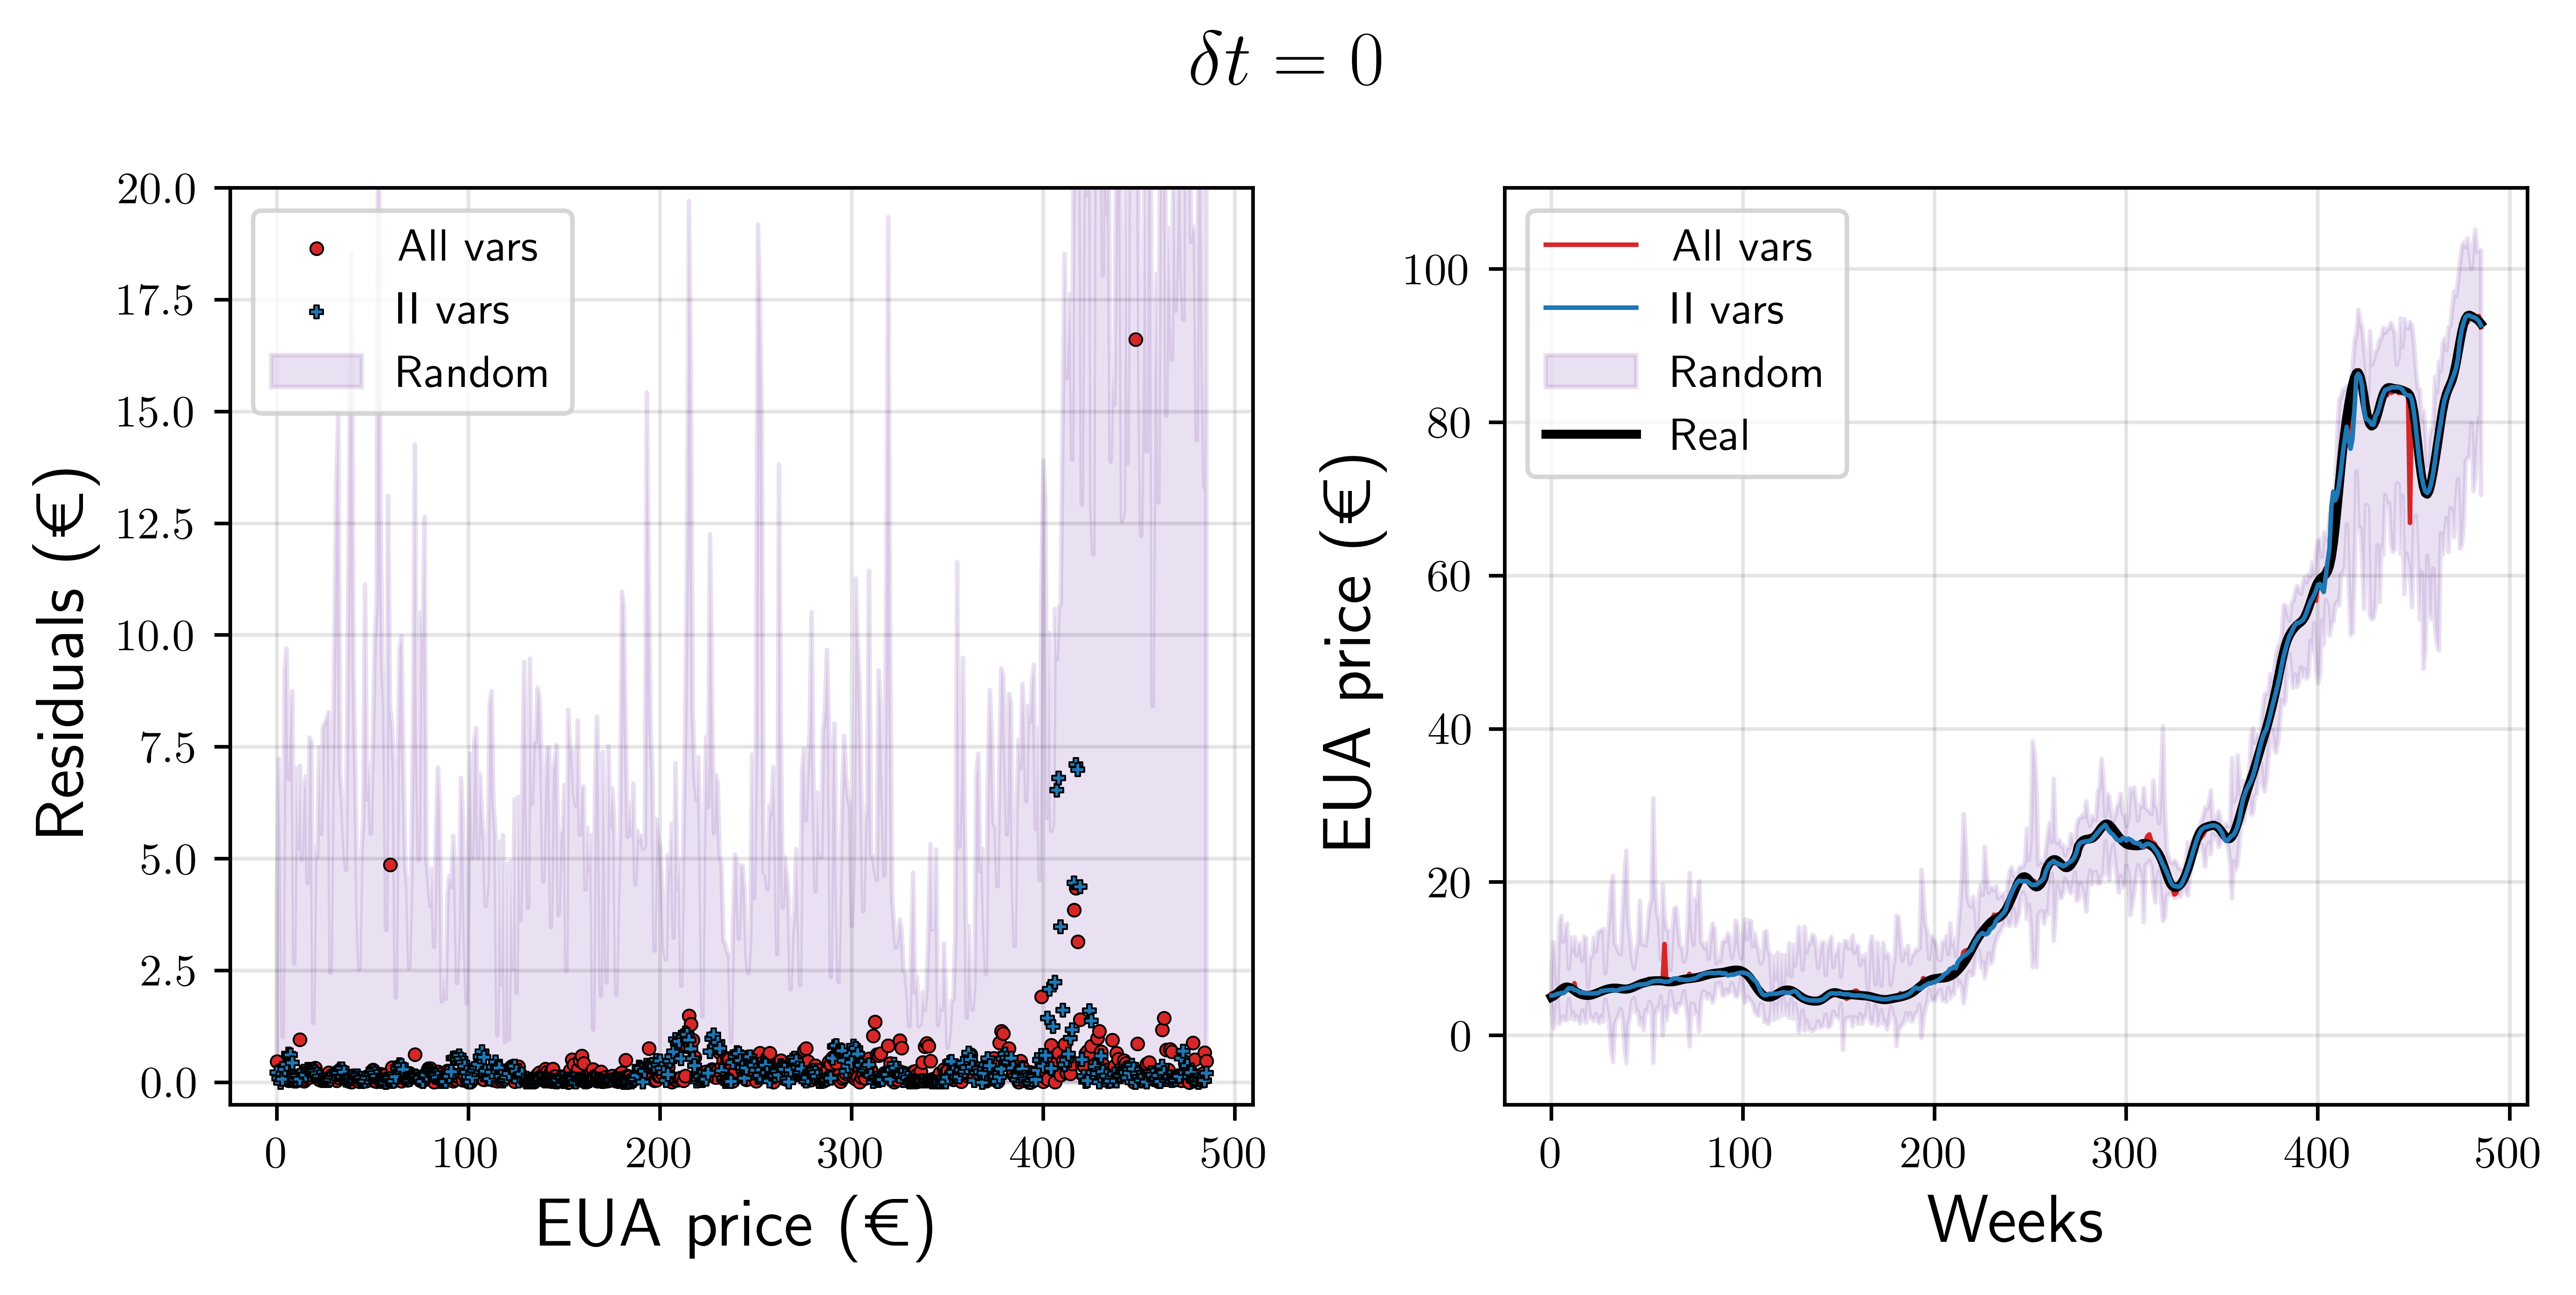

In [52]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), dpi = 700)
ax1.scatter(np.arange(486), residuals_all, color='tab:red', edgecolor='k', label='All vars', zorder=10, s=8, lw=0.4)
ax1.scatter(np.arange(486),residuals_im, color='tab:blue', edgecolor='k', label='II vars', zorder=20, s=8, lw=0.4, marker="P")
ax1.fill_between(np.arange(486), 0, mean_random_residuals + std_random_residuals, color="tab:purple", alpha=0.2, label="Random")
ax1.set_ylim(bottom=-0.5, top=20)
ax1.grid(axis='both', alpha=.1, color ='k')
ax1.set_ylabel("Residuals (€)", fontsize=15)
ax1.set_xlabel("EUA price (€)", fontsize=15)
ax1.legend(loc='upper left')
ax2.plot(y_pred_now_alls_sorted_, label="All vars", color="tab:red", lw=1, zorder=5)
ax2.plot(y_pred_now_ims_sorted_, label="II vars", color="tab:blue", lw=1, zorder=15)
ax2.fill_between(np.arange(486), mean_random_prediction_ - std_random_prediction_, mean_random_prediction_ + std_random_prediction_, color="tab:purple", alpha=0.2, label="Random")
ax2.plot(target_w_, label="Real", color="k", alpha=1, lw=2, zorder=5, linestyle="-")
ax2.legend(loc='upper left')
ax2.grid(axis='both', alpha=.1, color='k')
ax2.set_xlabel("Weeks", fontsize=15)
ax2.set_ylabel("EUA price (€)", fontsize=15)
fig.suptitle(r"$\delta t =0$", fontsize=17)
plt.tight_layout()
plt.savefig("../Figures/Fig7_1_1_Nowcasting_weekly.png", dpi = 700, bbox_inches='tight')

Figure 9: Performance of a GP model build on three informative variables or on all variables, with mean random prediction. For nowcasting, the figure reports a scatter plot of the residuals vs the test set as well as the standardized EUA predictions as time series

In [53]:
%reset -f

In [54]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn.gaussian_process.kernels as k
import sklearn.model_selection as ms

from dadapy import Data
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
from itertools import combinations

plt.rcParams['text.usetex'] = True

In [55]:
np.random.seed(0)

In [56]:
df = pd.read_excel('../Data/Dataset_eua_IMv4.3.xlsx')
eua = df['eua_last']

In [57]:
files = ["../Data/weekly_data.txt"]
file_labels = ["Weekly"]
X_labels = np.array(['EUA','GPR', 'VSTOXX', 'Unc. EUR/USD', 'Unc. EUR/JPY', 'Unc. EUR/GBP', 'Unc. EUR/CHF',
       'Natural Gas', 'Elec. price SPAIN', 'Elec. price GER', 'Elec. price IT',
       'Elec. price FR', 'Brent Oil', 'Coal', 'Gold', 'EUR/USD Spot',
       'EUR/JPY Spot', 'EUR/GBP Spot', 'EUR/CHF Spot',
       'Bloom. Energy price index', 'Solactive ESG fossil index',
       'S&P Euro50 Env. index', 'MSCI EU Energy sec. index', 'ERIX index', 'EUROnext100', 'IBEX35', 'DAX',
       'CAC', 'FTSEmib', 'EUROSTOXX. Elect. index', '10 Year Bond yield', '3 Month Bond Yield',
       'Inflation', 'GDP'])

In [58]:
data_sets = []
for file in files:
    data = np.genfromtxt(file)
    data_sets.append(data)

n_roll = 1
data = data_sets[0]
target_w = data[:, 0][:, None]
target_w = np.roll(target_w, -n_roll)[:-n_roll]
X_w = data[:, :]
X_w = X_w[:-n_roll]
X_w_im = X_w
best_sets_list = [0,33,31]
X_w_im = X_w_im[:, best_sets_list]

In [59]:
kernel_w_s =k.Matern(length_scale=1, length_scale_bounds=(1e-5, 1e5), nu=1.5)
kf = KFold(n_splits=5, shuffle=True, random_state=0)

In [60]:
test_indices_alls = []
y_pred_for_alls = []
r_2_for_alls = []
mse_list_for_all = []
mse_list_for_im = []

for train_index, test_index in kf.split(X_w):
    test_indices_alls.append(test_index)
    X_train_for_all, X_test_for_all = X_w[train_index], X_w[test_index]
    y_train_for_all, y_test_for_all = target_w[train_index], target_w[test_index]
    gpr_for_all = GaussianProcessRegressor(kernel=kernel_w_s, n_restarts_optimizer=10, alpha=0.001, normalize_y=True)
    gpr_for_all.fit(X_train_for_all, y_train_for_all)
    y_pred_for_all, sigma_for_all = gpr_for_all.predict(X_test_for_all, return_std=True)
    y_pred_for_alls.append(y_pred_for_all)
    r_2_for_all = gpr_for_all.score(X_test_for_all, y_test_for_all)
    r_2_for_alls.append(r_2_for_all)
    mse_list_for_all.append(mean_squared_error(y_test_for_all, y_pred_for_all))

all_test_indices_alls = np.concatenate([ti for ti in test_indices_alls])
to_sort_alls = np.argsort(all_test_indices_alls)
y_pred_for_alls = np.concatenate([y_pred_for_all for y_pred_for_all in y_pred_for_alls])

In [61]:
std_for_all = np.std(mse_list_for_all)
print("STD for All:", std_for_all)

se_for_all = std_for_all / np.sqrt(5)
print("SE for All:  ",se_for_all)

All_Forecasting_score = gpr_for_all.score(X_test_for_all, y_test_for_all,sample_weight=None)
print("All now - R^2: ", All_Forecasting_score)

mse_for_all = np.mean(mse_list_for_all)
print("All for - MSE: ", mse_for_all)

STD for All: 0.000922012695396625
SE for All:   0.0004123366126049322
All now - R^2:  0.9978388363674047
All for - MSE:  0.0006238245706245524


In [62]:
test_indices_ims = []
y_pred_for_ims = []
r_2_for_ims = []

for train_index, test_index in kf.split(X_w_im):
    test_indices_ims.append(test_index)
    X_train_for_im, X_test_for_im = X_w_im[train_index], X_w_im[test_index]
    y_train_for_im, y_test_for_im = target_w[train_index], target_w[test_index]
    gpr_for_im = GaussianProcessRegressor(kernel=kernel_w_s, n_restarts_optimizer=10, alpha=0.001, normalize_y=True)
    gpr_for_im.fit(X_train_for_im, y_train_for_im)
    y_pred_for_im, sigma_for_im = gpr_for_im.predict(X_test_for_im, return_std=True)
    y_pred_for_ims.append(y_pred_for_im)
    r_2_for_im = gpr_for_im.score(X_test_for_im, y_test_for_im)
    r_2_for_ims.append(r_2_for_im)
    mse_list_for_im.append(mean_squared_error(y_test_for_im, y_pred_for_im))

all_test_indices_ims = np.concatenate([ti for ti in test_indices_ims])
to_sort_ims = np.argsort(all_test_indices_ims)
y_pred_for_ims = np.concatenate([y_pred_for_im for y_pred_for_im in y_pred_for_ims])

In [63]:
std_for_im = np.std(mse_list_for_im)
print("STD for Imb: ", std_for_im)

se_for_im = std_for_im / np.sqrt(5)
print("SE for Imb: ", se_for_im)

II_Forecasting_score = gpr_for_im.score(X_test_for_im, y_test_for_im,sample_weight=None)
print("Imb for - R^2: ", II_Forecasting_score)

mse_for_im = np.mean(mse_list_for_im)
print("Imb for - MSE: ", mse_for_im)

STD for Imb:  4.322290661974397e-05
SE for Imb:  1.9329871477374633e-05
Imb for - R^2:  0.9998359176988608
Imb for - MSE:  0.00010906095989786158


In [64]:
x = np.arange(0, 33, 1)
comb = combinations(x,3)
comb = np.array(list(comb))

np.random.seed(23)
ind_shu = np.random.shuffle(comb)

n = 30
r = []
for i in range(n):
    r.append(comb[i])

In [65]:
mse_list_for_r = []
test_indices_rs = []
y_pred_for_rs = []

r_2_for_rs = []
for i in range(n):
    r_2_for_rs.append([])

r_2_for_r = []
for i in range(n):
    r_2_for_r.append([])

In [66]:
for i, c in enumerate(r):
    y_pred_for_r_2 = []
    test_indices_rs_2 = []
    mse_list_for_r_2 = []
    for train_index, test_index in kf.split(X_w[:, c]): 
        test_indices_rs_2.append(test_index)
        X_train_for_r, X_test_for_r = X_w[train_index][:, c], X_w[test_index][:, c]
        y_train_for_r, y_test_for_r = target_w[train_index], target_w[test_index]
        gpr_for_r = GaussianProcessRegressor(kernel=kernel_w_s, n_restarts_optimizer=10, alpha=0.001, normalize_y=True)
        gpr_for_r.fit(X_train_for_r, y_train_for_r)
        y_pred_for_r, sigma_for_r = gpr_for_r.predict(X_test_for_r, return_std=True)
        y_pred_for_r_2.append(y_pred_for_r)
        r_2_for_r[i] = gpr_for_r.score(X_test_for_r, y_test_for_r)
        r_2_for_rs[i].append(r_2_for_r[i])
        mse_list_for_r_2.append(mean_squared_error(y_test_for_r, y_pred_for_r))
    mse_list_for_r.append(mse_list_for_r_2)
    test_indices_rs.append(test_indices_rs_2)
    y_pred_for_rs.append(y_pred_for_r_2)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/gaussian_process/_gpr.py:659: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/gaussian_process/_gpr.py:659: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/gaussian_process/_gpr.py:659: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the

In [67]:
mse_for_r_test = []
r_2_for_random_mean_test = []
se_for_r_test = []
to_sort_rs_app = []
for i in range(n):
    all_test_indices_rs = np.concatenate([ti for ti in test_indices_rs[i]])
    to_sort_rs = np.argsort(all_test_indices_rs)
    to_sort_rs_app.append(to_sort_rs)
    y_pred_for_rs[i] = np.concatenate([y_pred_for_r for y_pred_for_r in y_pred_for_rs[i]])
    mse_for_r = np.mean(mse_list_for_r[i])
    mse_for_r_test.append(mse_list_for_r)
    r_2_for_random_mean = np.mean(r_2_for_rs[i])
    r_2_for_random_mean_test.append(r_2_for_random_mean)
    std_for_r = np.std(mse_list_for_r[i])
    se_for_r_test.append(std_for_r/np.sqrt(5))

In [68]:
mean_score = np.mean([r_2_for_random_mean_test])
print("Random Mean R^2: ", mean_score)

mean_mse = np.mean([mse_for_r_test])
print("Random Mean MSE: ", mean_mse)

se_now_r = np.mean(se_for_r_test)
print("Random SE: ", se_now_r)

Random Mean R^2:  0.9641058971272098
Random Mean MSE:  0.03484712266434468
Random SE:  0.006830704286395195


In [69]:
random_pred_sorted = []

for _ in range(n):
    random_pred_sorted.append(y_pred_for_rs[_][to_sort_rs_app[_]])

In [70]:
mean_random_prediction = np.mean(random_pred_sorted, axis=0)
std_random_prediction = np.std(random_pred_sorted, axis=0)

y_pred_for_alls_sorted = y_pred_for_alls[to_sort_alls]
y_pred_for_ims_sorted = y_pred_for_ims[to_sort_ims]

In [71]:
residuals_all = abs((target_w[:, 0] - y_pred_for_alls_sorted)*np.std(eua))
residuals_im = abs((target_w[:, 0] - y_pred_for_ims_sorted)*np.std(eua))
residuals_r = abs((target_w[None, :, 0] - random_pred_sorted)*np.std(eua))

In [72]:
y_pred_for_alls_ = y_pred_for_alls * np.std(eua) + np.mean(eua)
y_pred_for_ims_ = y_pred_for_ims * np.std(eua) + np.mean(eua)
y_pred_for_rs_ = mean_random_prediction * np.std(eua) + np.mean(eua)
target_w_ = target_w * np.std(eua) + np.mean(eua)

y_pred_for_alls_sorted_ = y_pred_for_alls_sorted * np.std(eua) + np.mean(eua)
y_pred_for_ims_sorted_ = y_pred_for_ims_sorted * np.std(eua) + np.mean(eua)
mean_random_prediction_ = mean_random_prediction * np.std(eua) + np.mean(eua)
std_random_prediction_ = std_random_prediction * np.std(eua)

In [73]:
mean_random_residuals = np.mean(residuals_r, axis=0)
std_random_residuals = np.std(residuals_r, axis=0)

sort_by_target = np.argsort(target_w[:, 0])
mean_random_residuals_target_sort = mean_random_residuals[sort_by_target]
std_random_residuals_target_sort = std_random_residuals[sort_by_target]

residuals_all_target_sort = residuals_all[sort_by_target]
residuals_im_target_sort = residuals_im[sort_by_target]

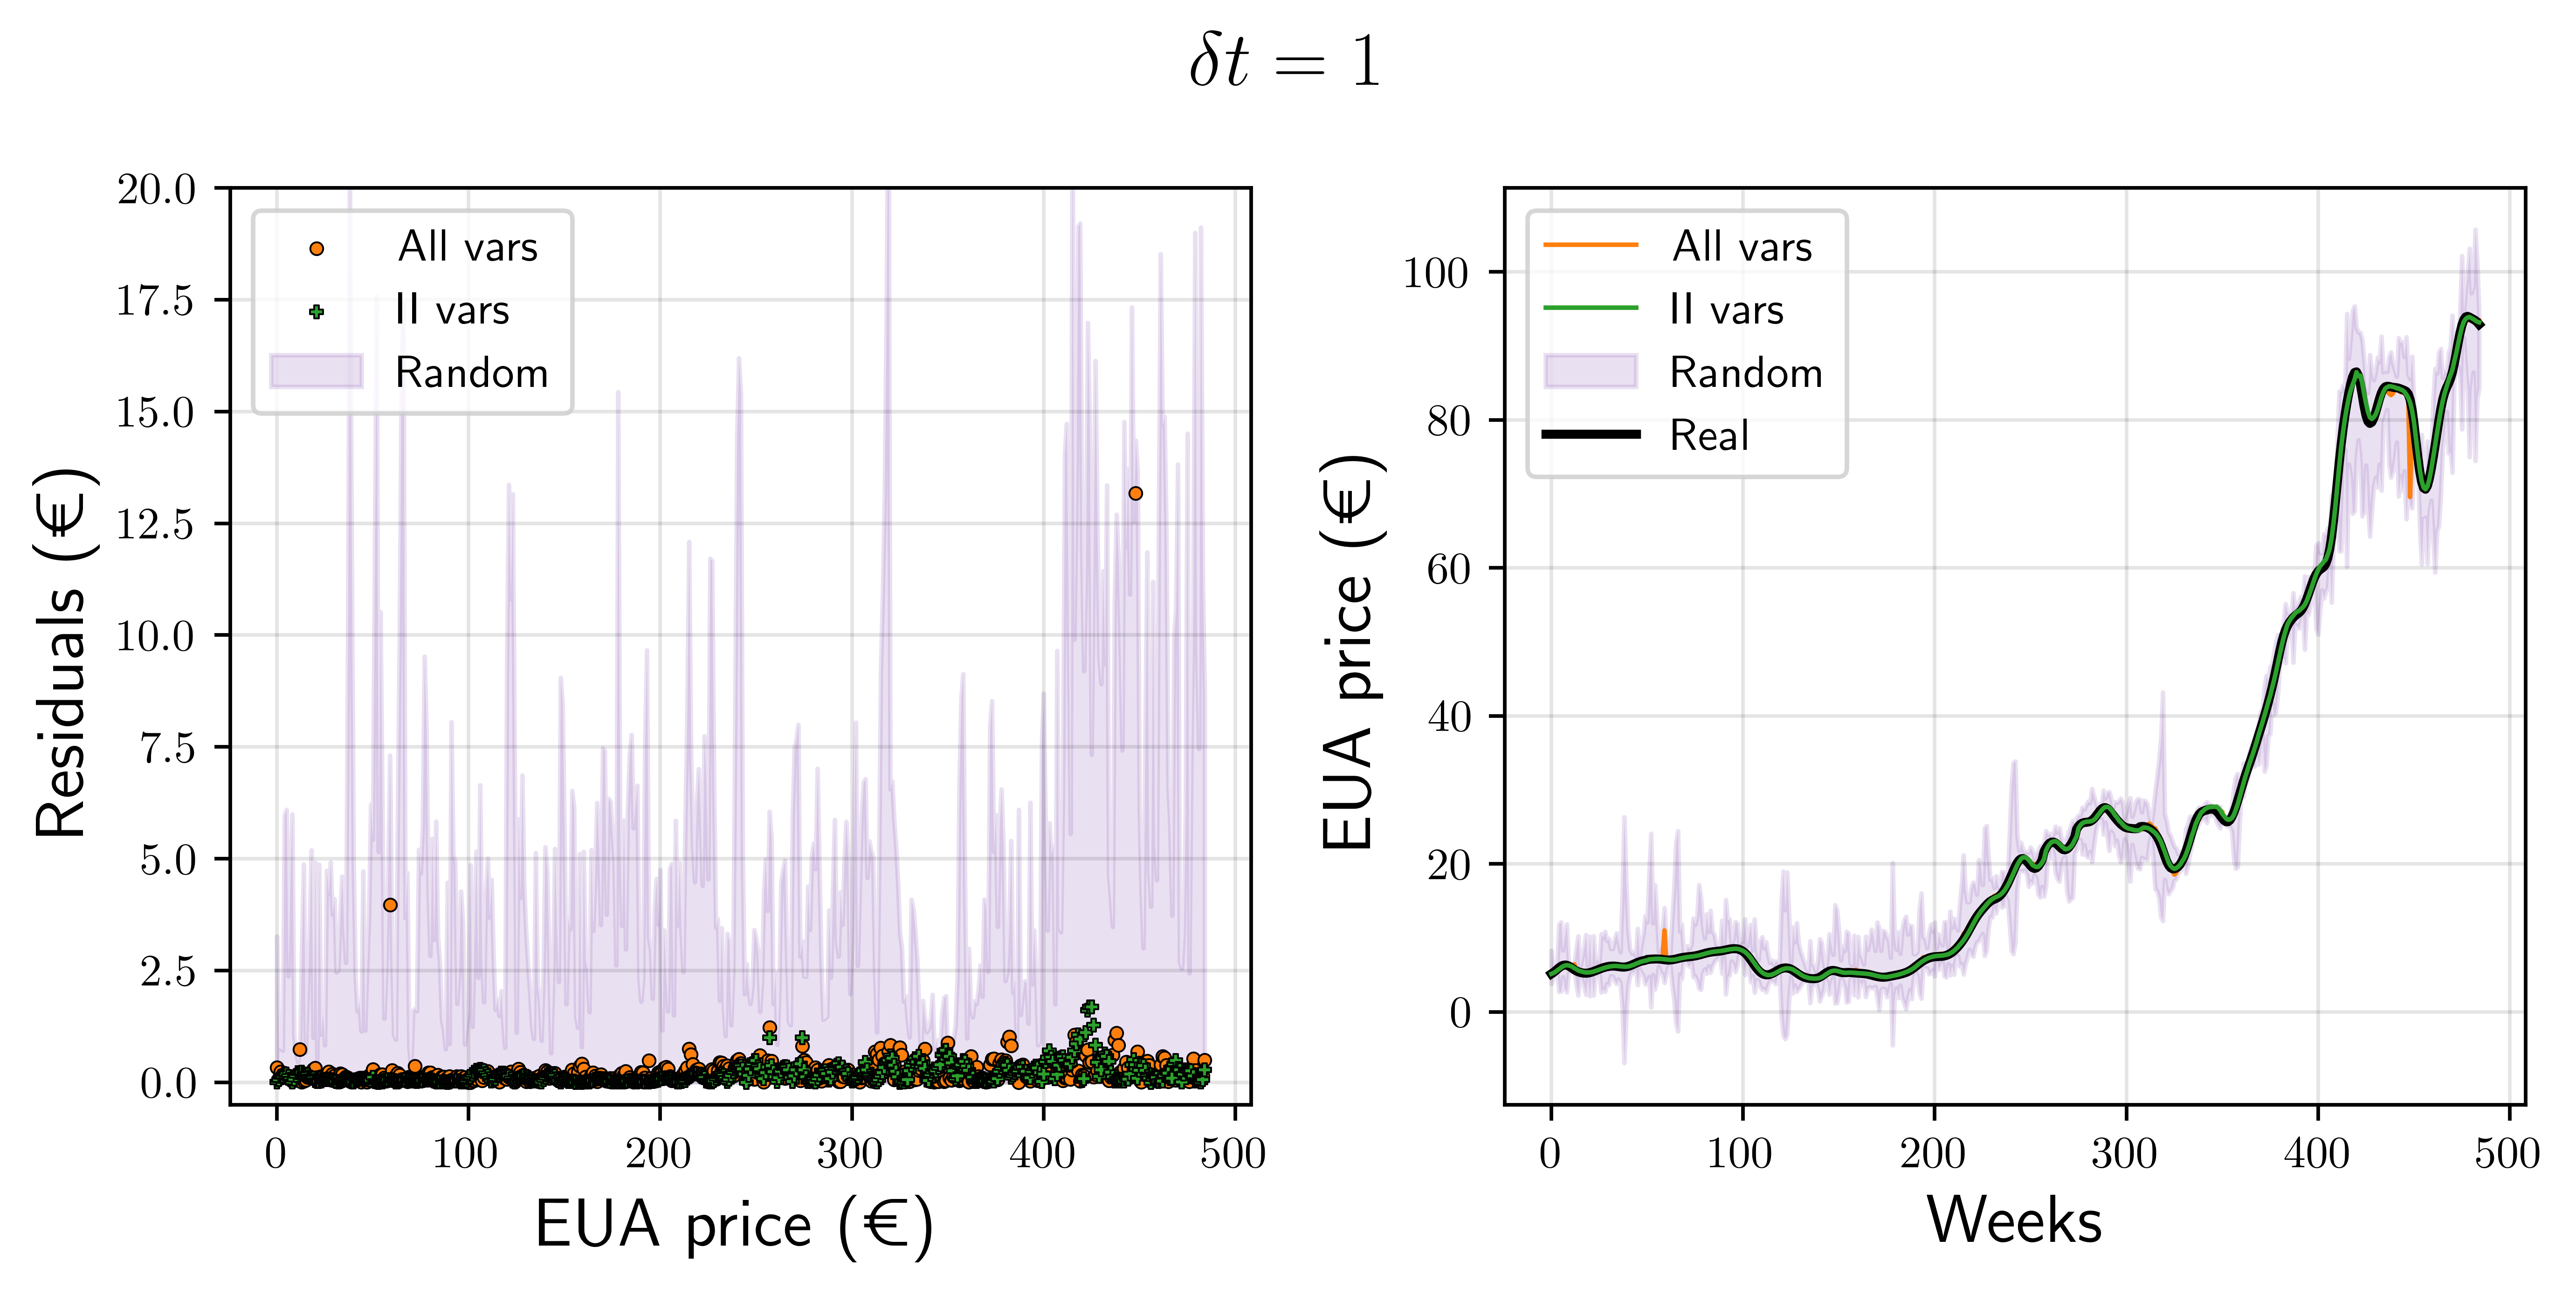

In [74]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), dpi = 700)
ax1.scatter(np.arange(485), residuals_all, color='tab:orange', edgecolor='k', label='All vars', zorder=10, s=8, lw=0.4)
ax1.scatter(np.arange(485),residuals_im, color='tab:green', edgecolor='k', label='II vars', zorder=20, s=8, lw=0.4, marker="P")
ax1.fill_between(np.arange(485), 0, mean_random_residuals + std_random_residuals, color="tab:purple", alpha=0.2, label="Random")
ax1.set_ylim(bottom=-0.5, top=20)
ax1.grid(axis='both', alpha=.1, color ='k')
ax1.set_ylabel("Residuals (€)", fontsize=15)
ax1.set_xlabel("EUA price (€)", fontsize=15)
ax1.legend(loc='upper left')
ax2.plot(y_pred_for_alls_sorted_, label="All vars", color="tab:orange", lw=1, zorder=5)
ax2.plot(y_pred_for_ims_sorted_, label="II vars", color="tab:green", lw=1, zorder=15)
ax2.fill_between(np.arange(485), mean_random_prediction_ - std_random_prediction_, mean_random_prediction_ + std_random_prediction_, color="tab:purple", alpha=0.2, label="Random")
ax2.plot(target_w_, label="Real", color="k", alpha=1, lw=2, zorder=5, linestyle="-")
ax2.legend(loc='upper left')
ax2.grid(axis='both', alpha=.1, color='k')
ax2.set_xlabel("Weeks", fontsize=15)
ax2.set_ylabel("EUA price (€)", fontsize=15)
fig.suptitle(r"$\delta t =1$", fontsize=17)
plt.tight_layout()
plt.savefig("../Figures/Fig7_1_2_Forecasting_weekly.png", dpi = 700, bbox_inches='tight')

Figure 9: Performance of a GP model build on three informative variables or on all variables, with mean random prediction. For forecasting the figure reports a scatter plot of the residuals vs the test set as well as the standardized EUA predictions as time series